---
title: "🗓️ Week 4 - Classification & Metrics & Resampling Methods"
subtitle: "Theme: Supervised Learning"
author: "Dr. Ghita Berrada"
date: "14 February 2025"
format: 
  html:
    from: markdown+emoji
    page-layout: full
    toc: true
    toc-depth: 2
self-contained: true
---

Welcome to Week 4! This week, we go back to classification. But, before we start, let's do a bit of set up

⚙️ Set up

**Loading Python libraries**

In [95]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score,f1_score,balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import sweetviz as sv
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from lets_plot import *
LetsPlot.setup_html()

# Part 1: A tennis match outcome prediction problem

## Introducing the dataset

In this part, we'll be looking at a dataset about tennis^[credit to Vignesh for the idea thanks to his mention of GOAT on Slack😉]. The data contains match stats and player info for WTA (Women's Tennis Association) and ATP (Association of Tennis Professionals) between 1949 and 2021. The data is available on [Kaggle](https://www.kaggle.com/datasets/taylorbrownlow/atpwta-tennis-data?resource=download) and was originally sourced from [Jeff Sackmann's GitHub repository](https://github.com/JeffSackmann/tennis_atp) (which maintains the dataset and updates it on a regular basis).

In [56]:
df = pd.read_csv('../data/KaggleMatches.csv',low_memory=False)

For simplicity, we'll filter the original dataset so as to only retain ATP data. 

In [57]:
# filtering to only retain ATP data
df=df.query("league=='atp'")

We'll also filter the data to only retain data from 1969 onwards. 

Any ideas as to why we do that? 

And how do we do that?

In [58]:
df['tourney_date'] = pd.to_datetime(df['tourney_date'], errors='coerce')
comparison_date = pd.to_datetime('1969-01-01')
filtered_df = df[df['tourney_date'] > comparison_date]

Let's have a look at our data:

If the code below doesn't work, try running the following before:

```{python}
filtered_df['winner_seed'] = pd.to_numeric(filtered_df['winner_seed'], errors='coerce')
filtered_df['loser_seed'] = pd.to_numeric(filtered_df['loser_seed'], errors='coerce')
```

(thanks Charlie!)

                                             |          | [  0%]   00:00 -> (? left)


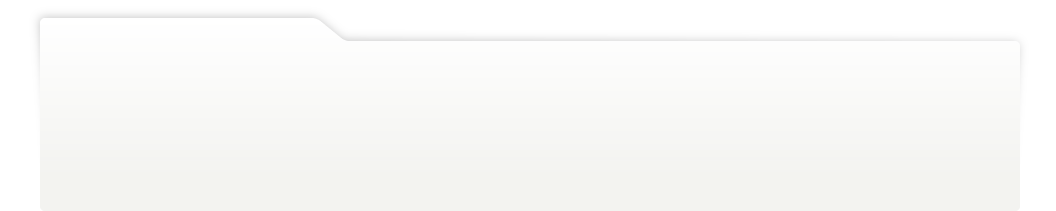
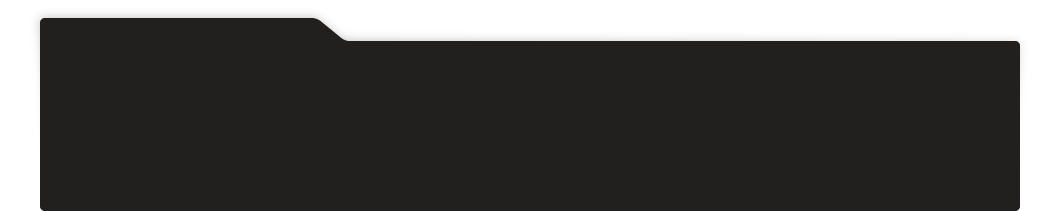
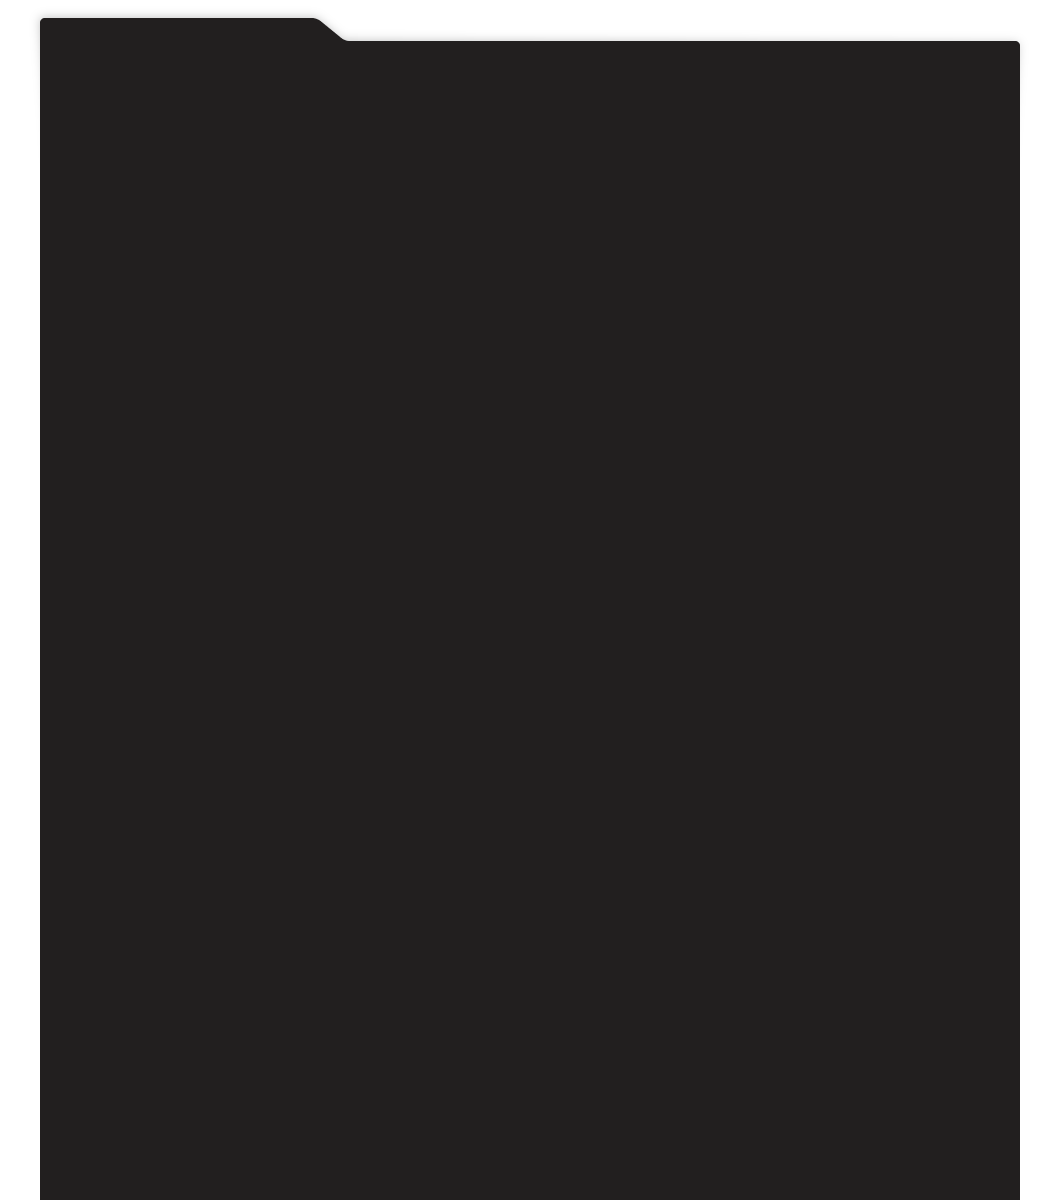
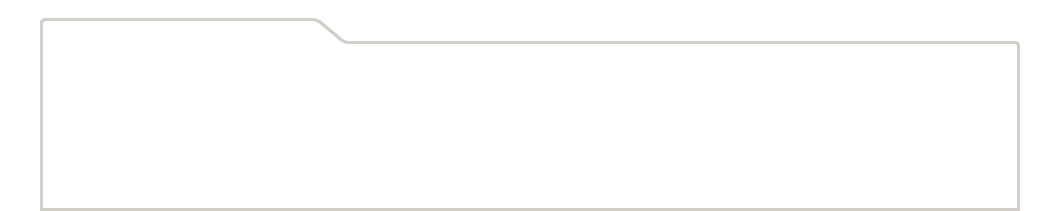
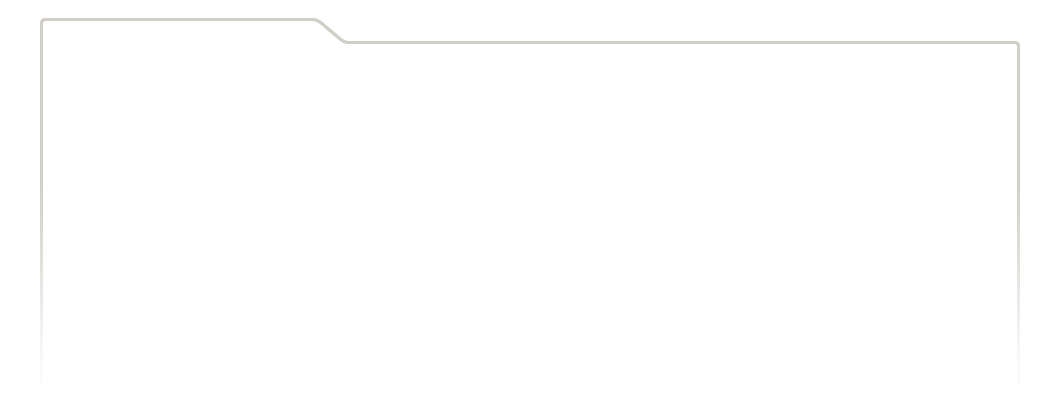
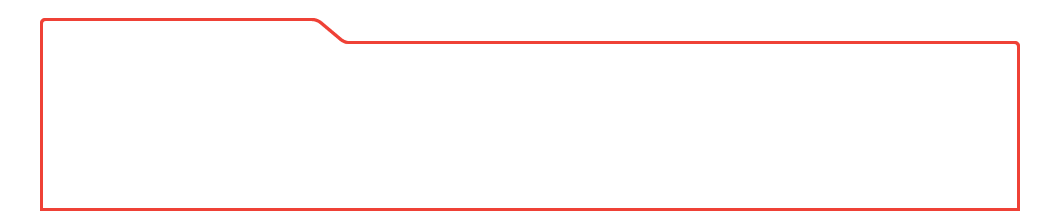
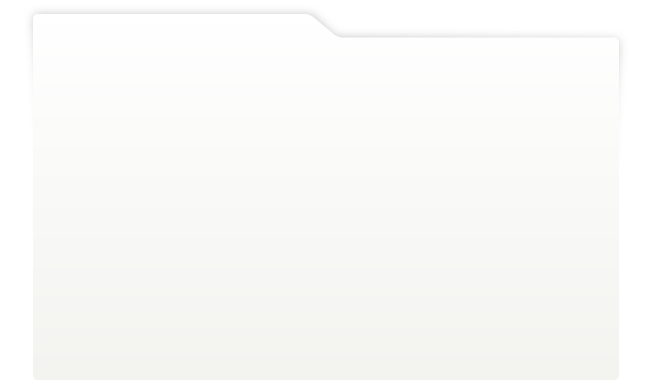
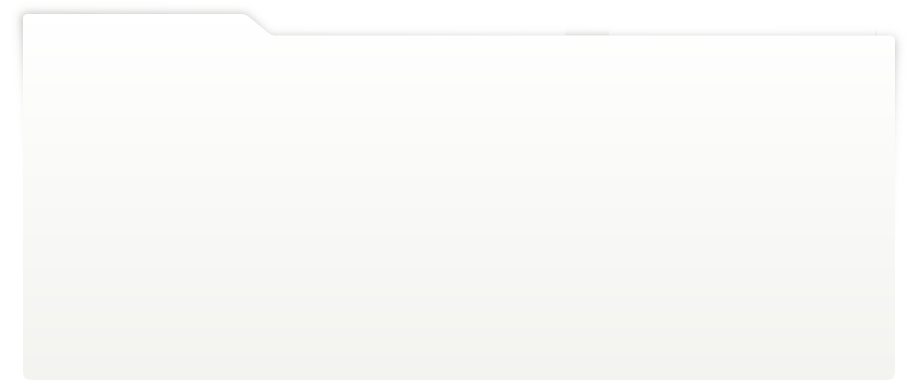
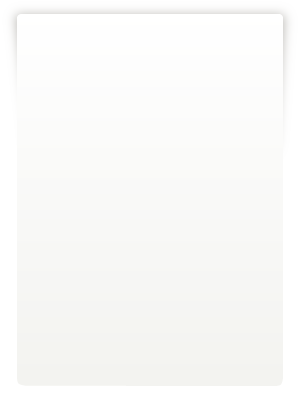
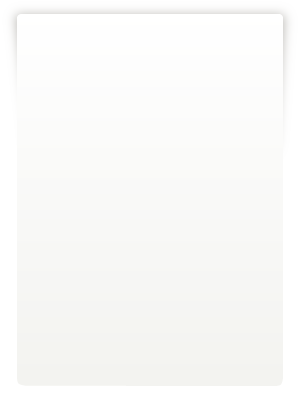
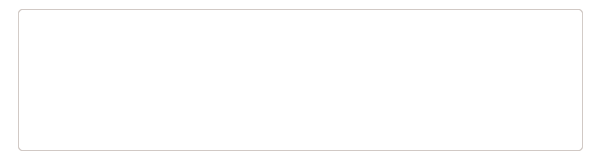
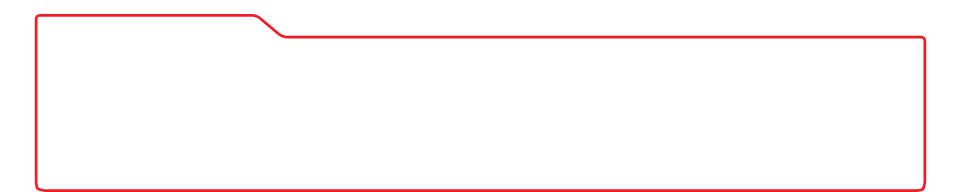
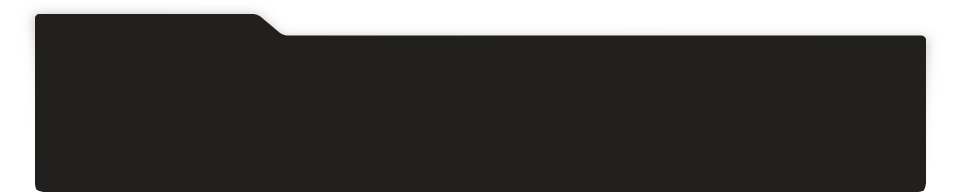
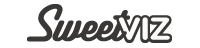
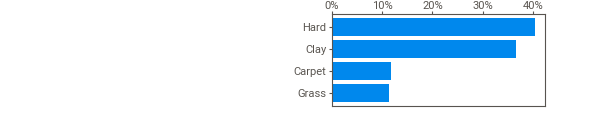
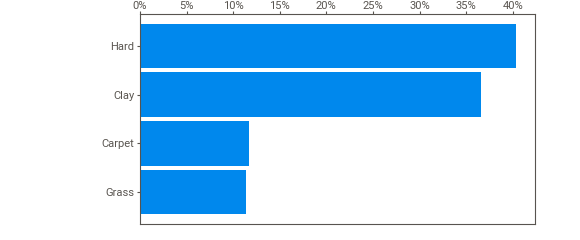
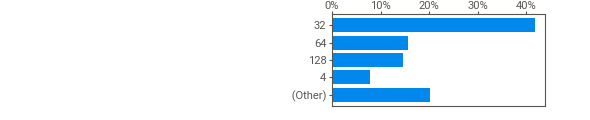
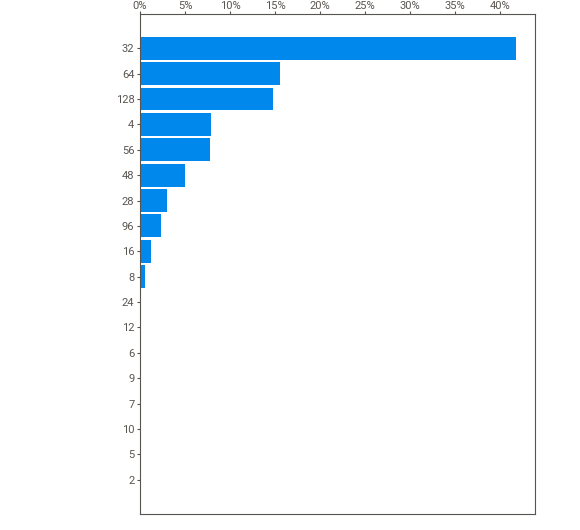
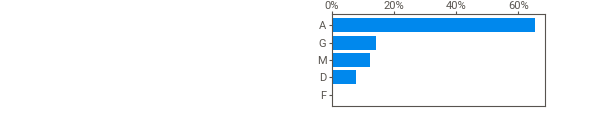
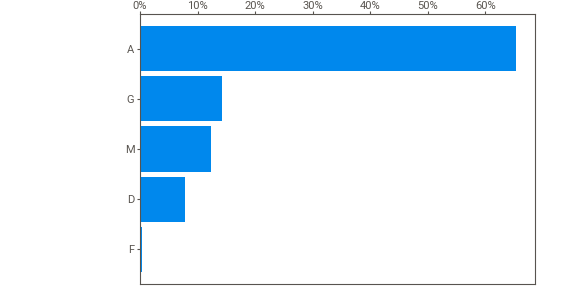
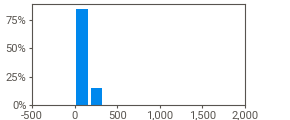
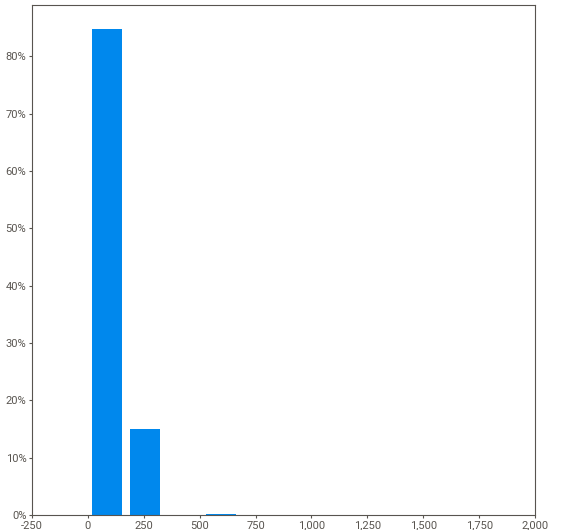
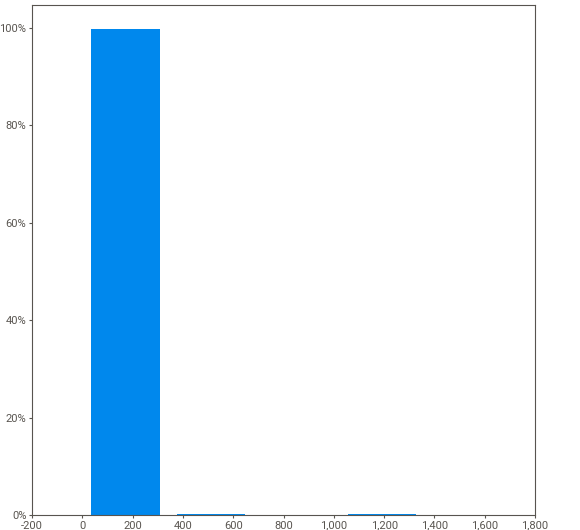
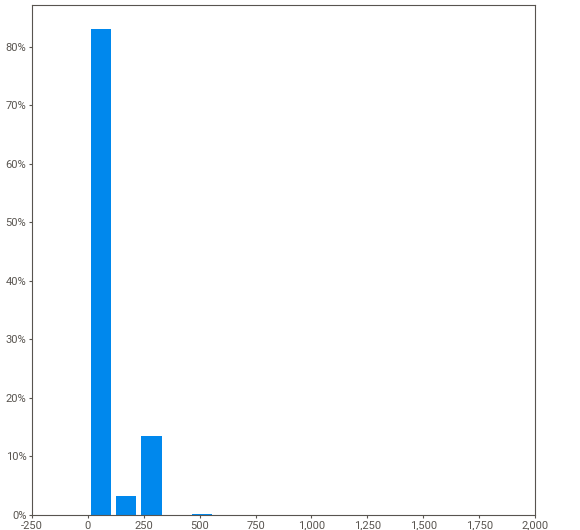
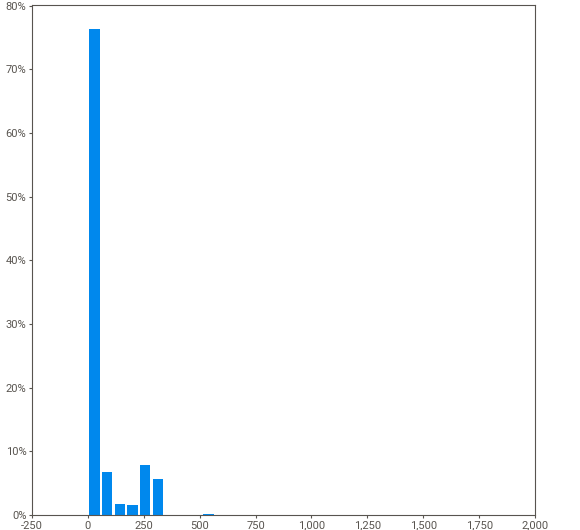
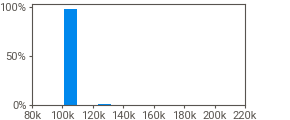
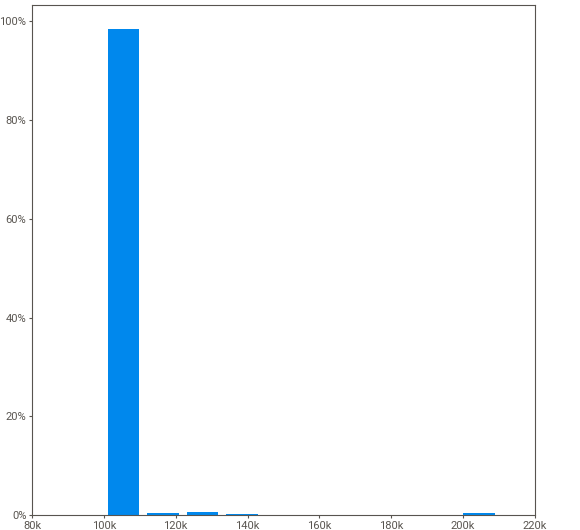
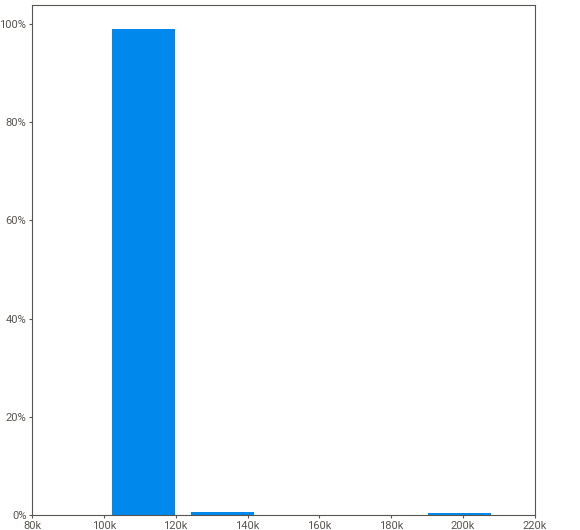
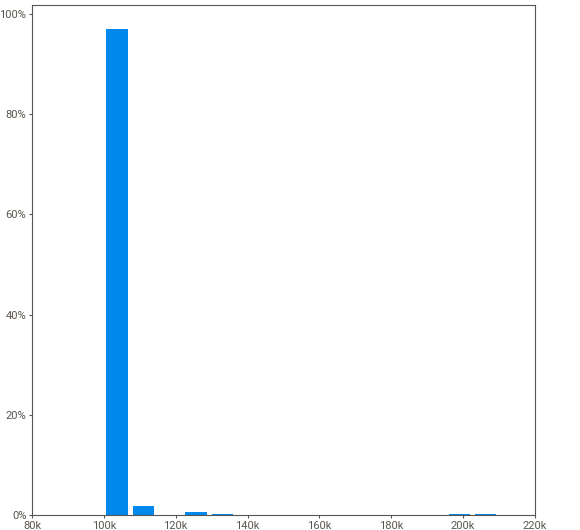
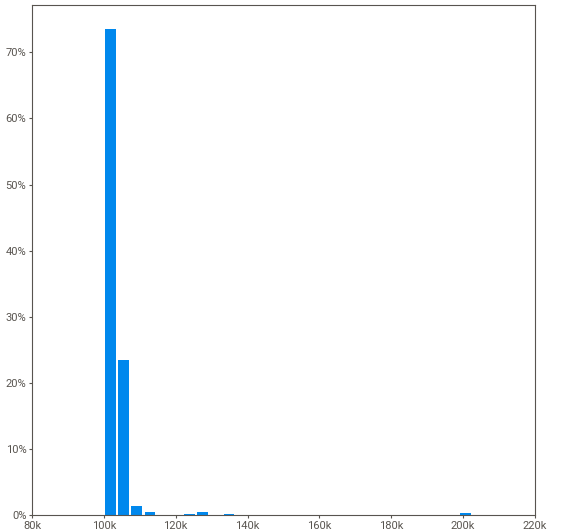
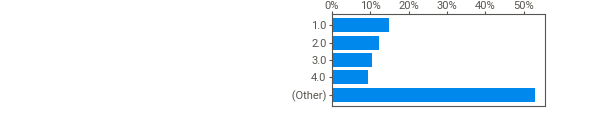
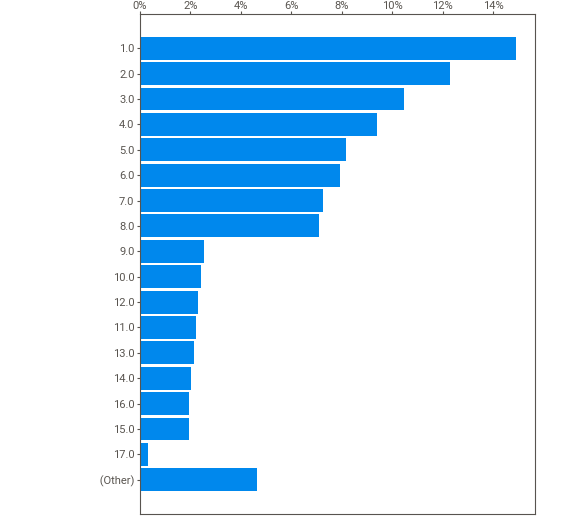
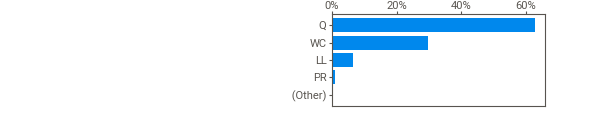
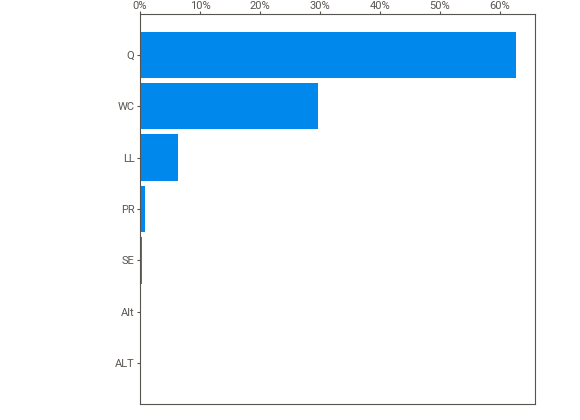
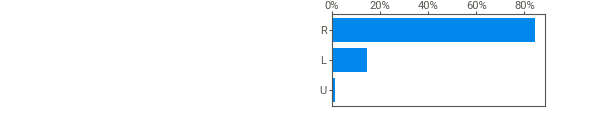
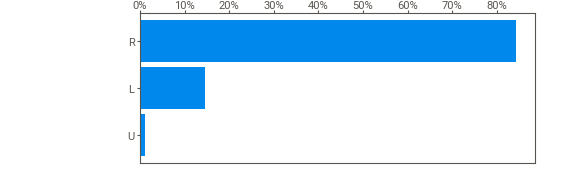
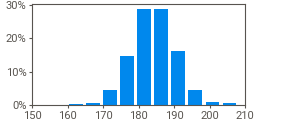
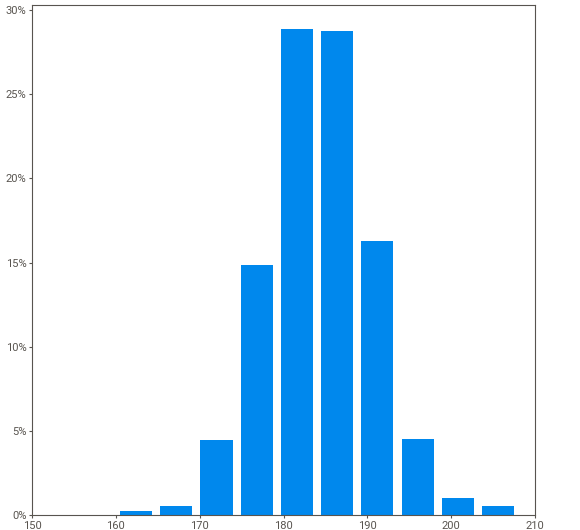
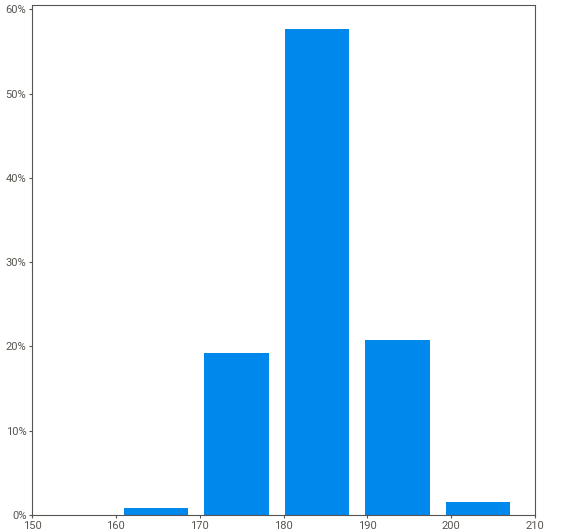
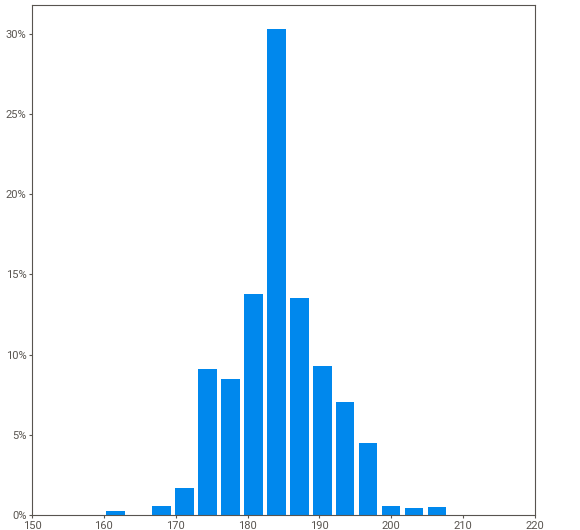
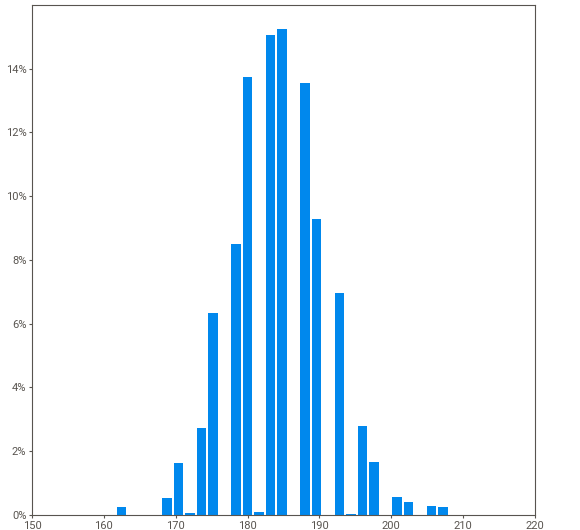
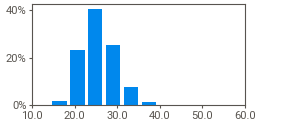
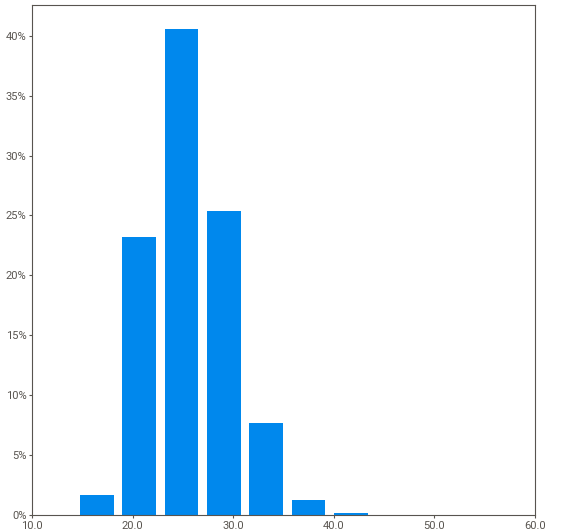
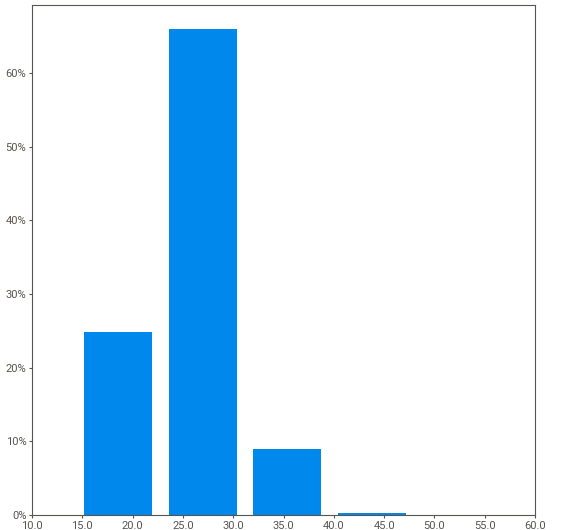
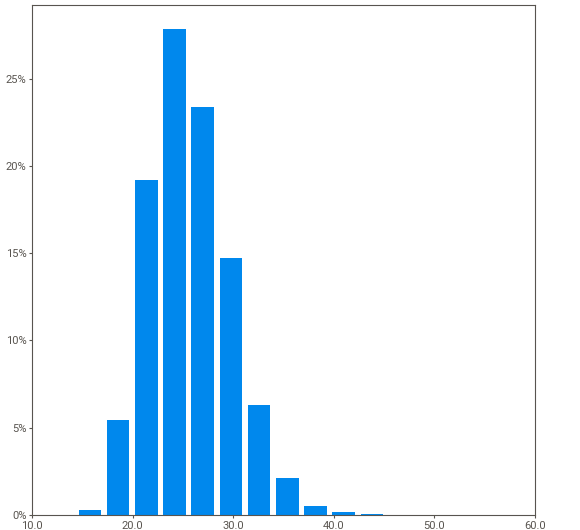
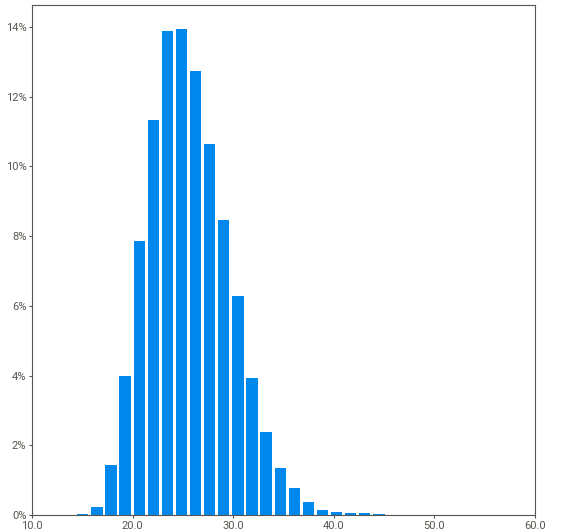
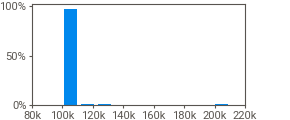
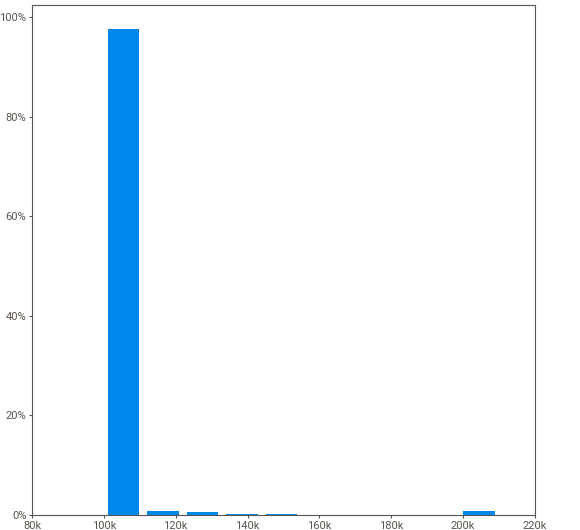
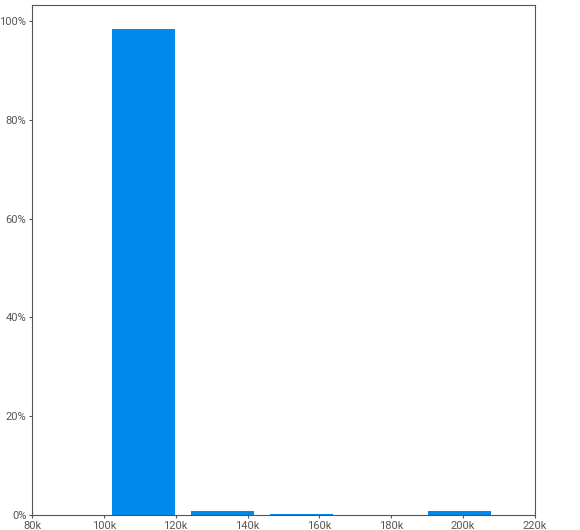
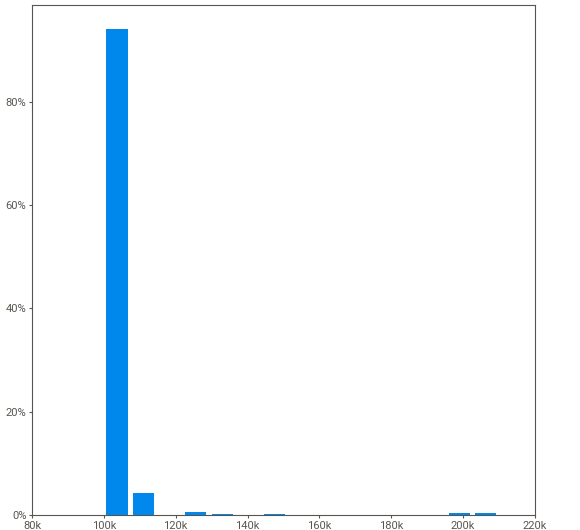
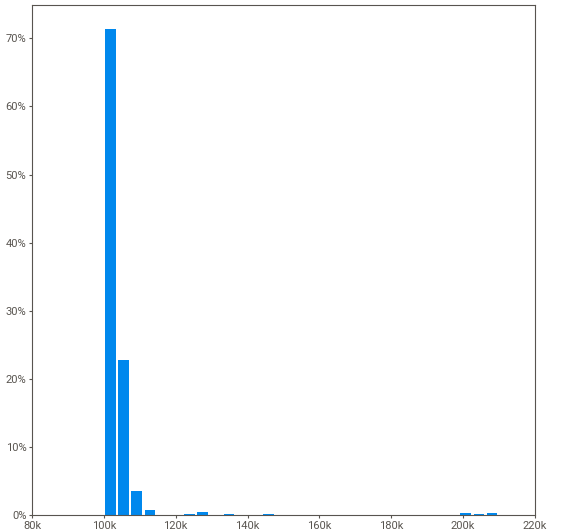
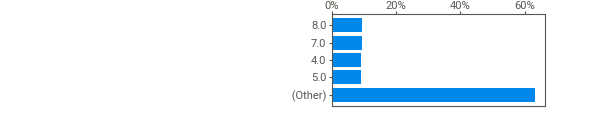
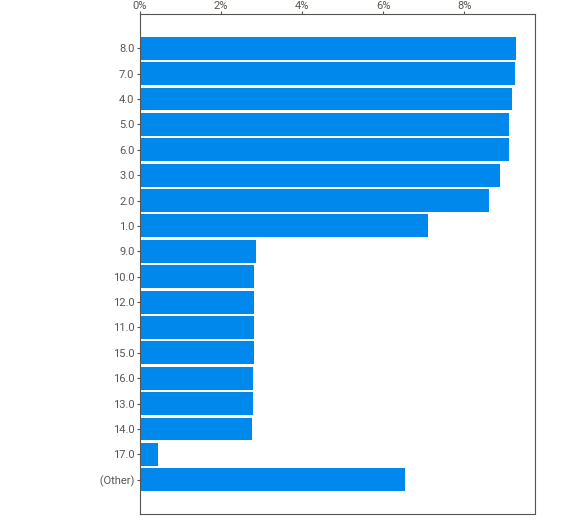
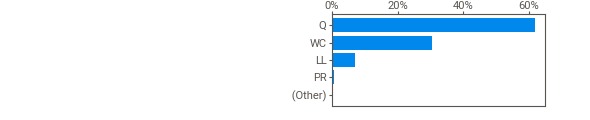
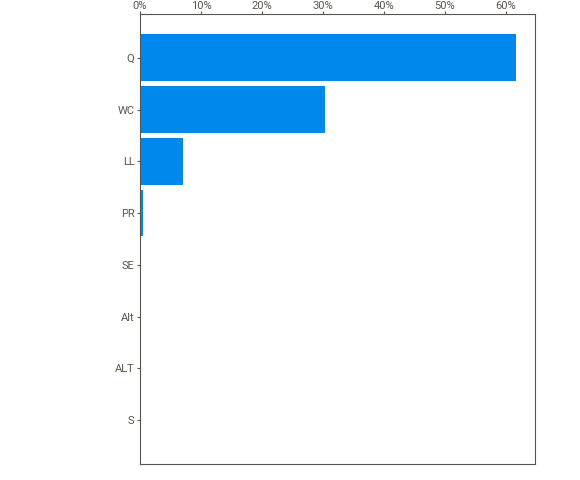
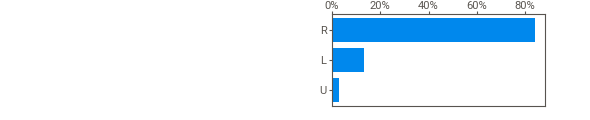
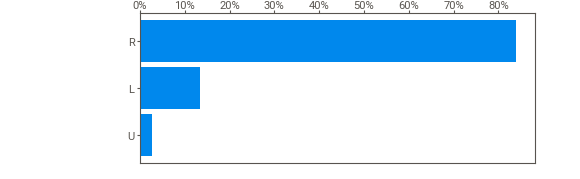
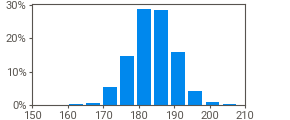
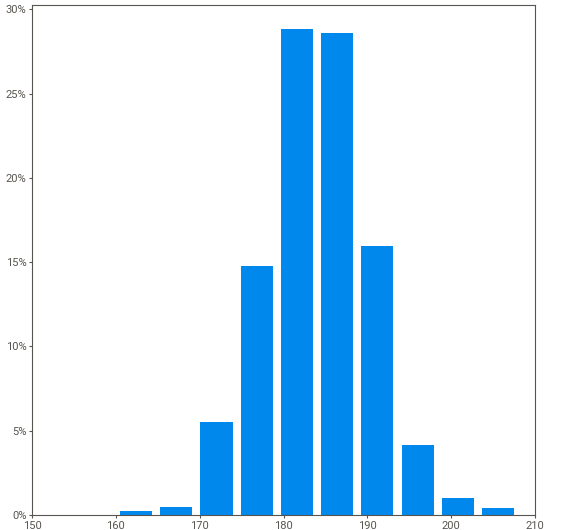
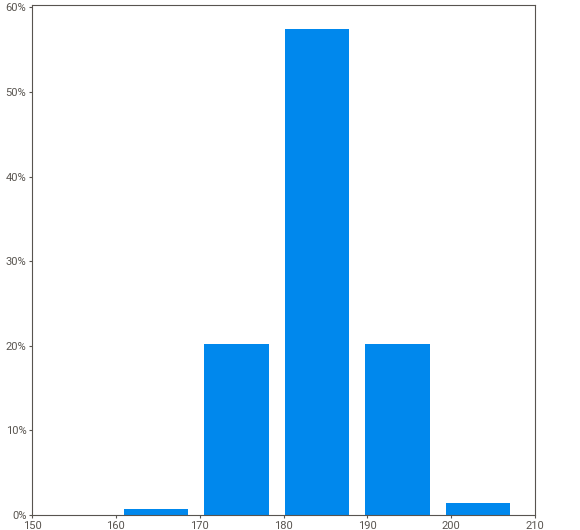
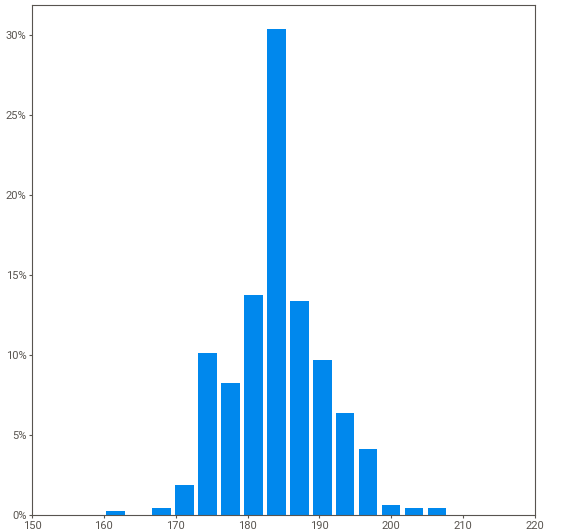
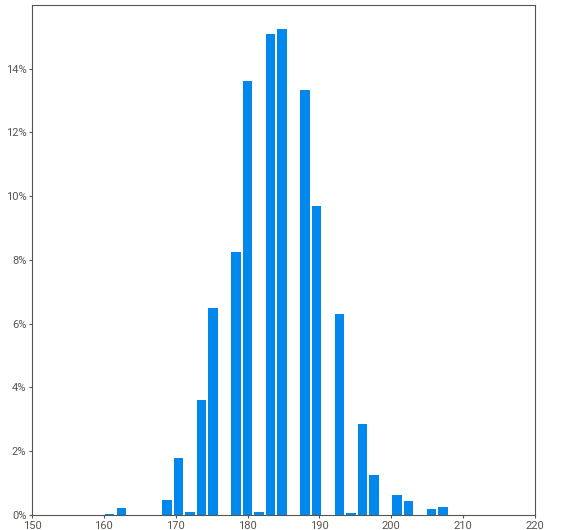
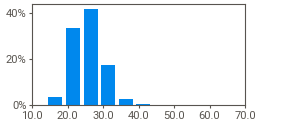
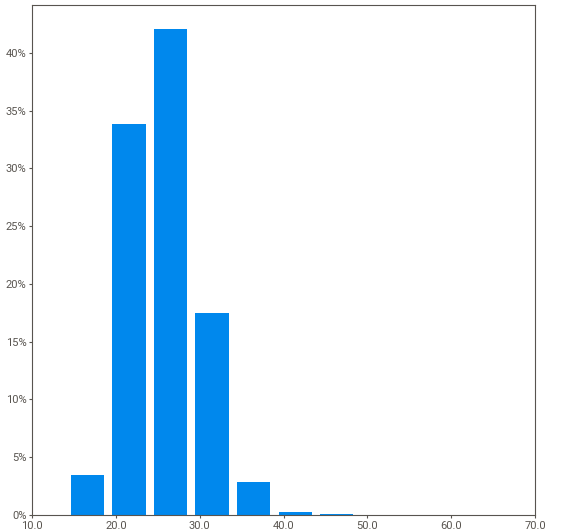
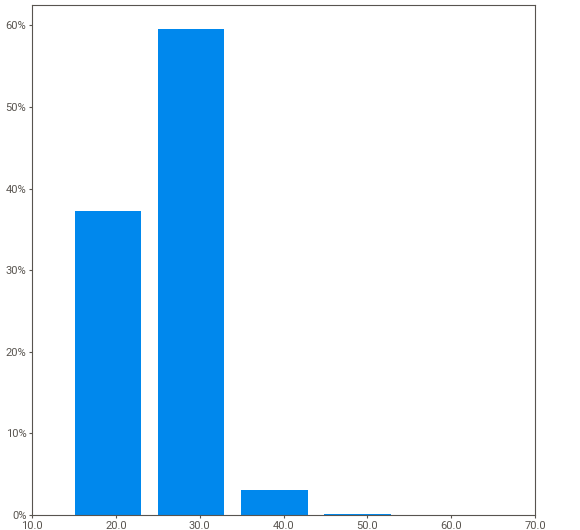
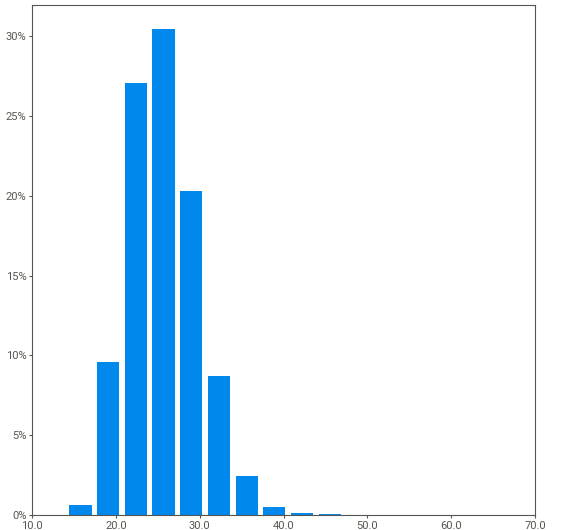
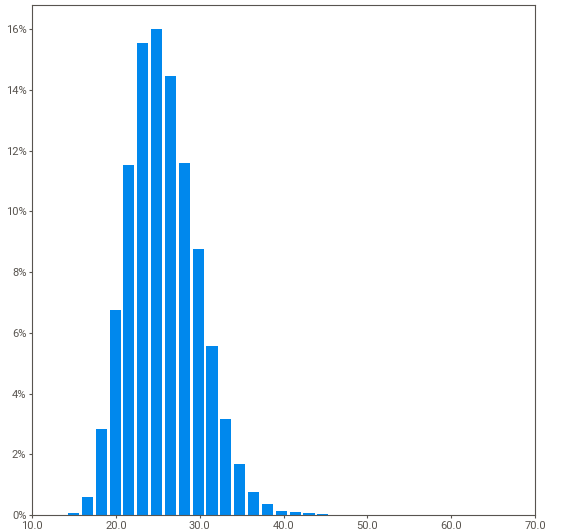
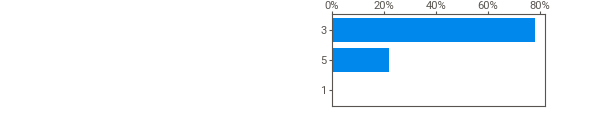
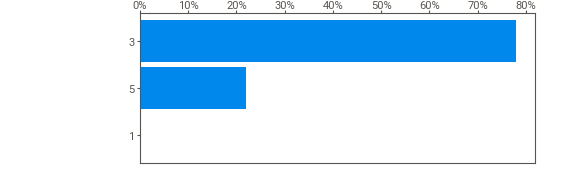
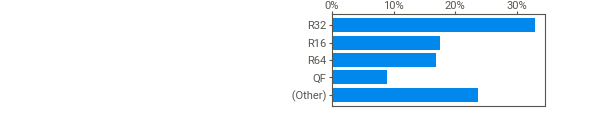
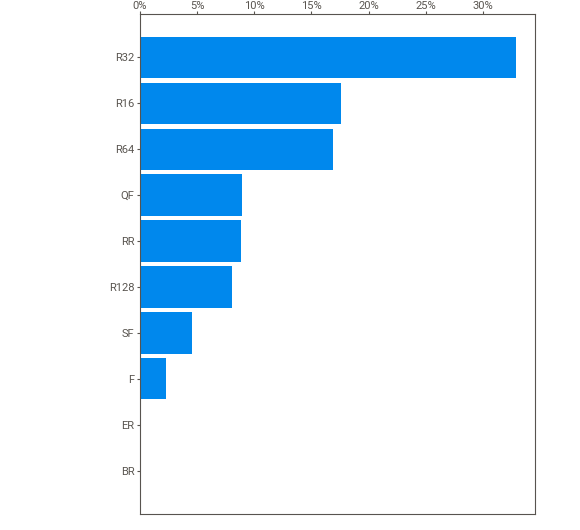
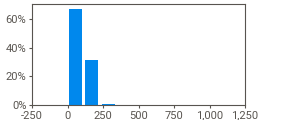
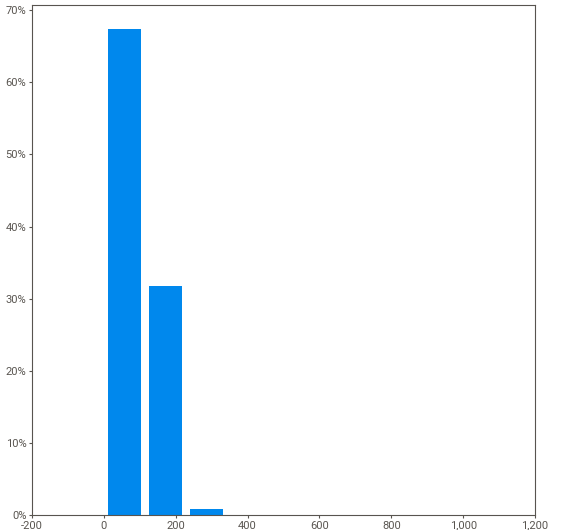
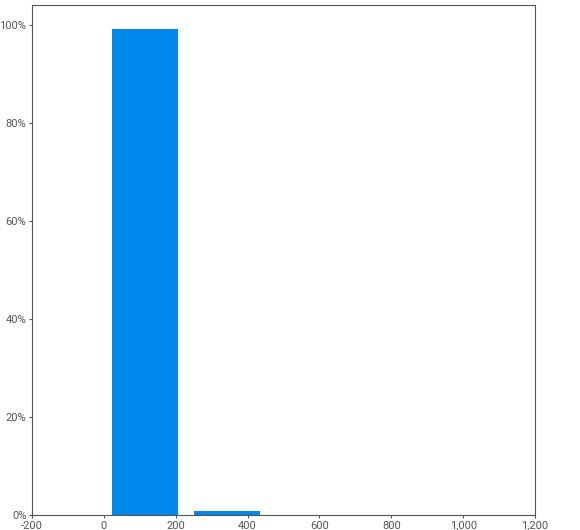
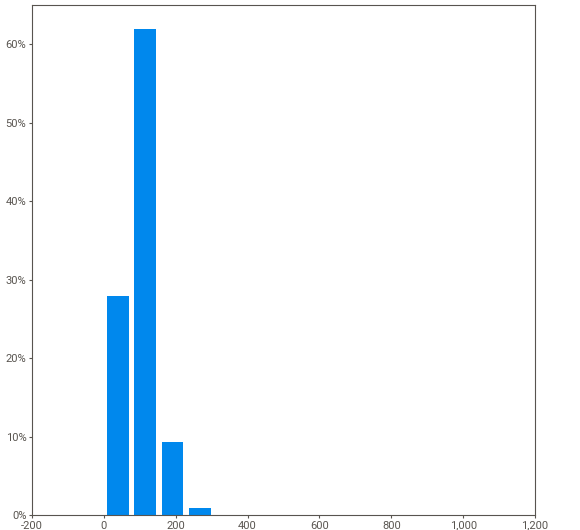
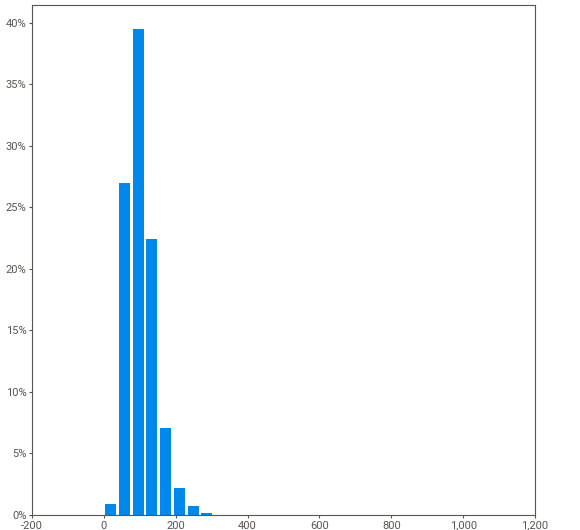
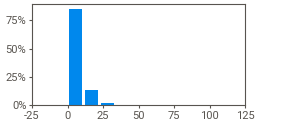
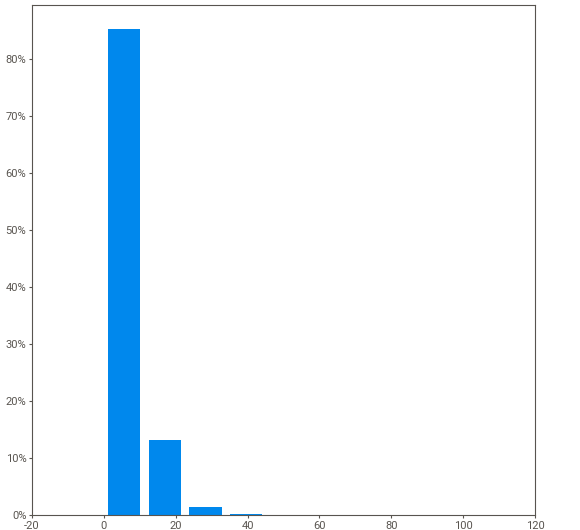
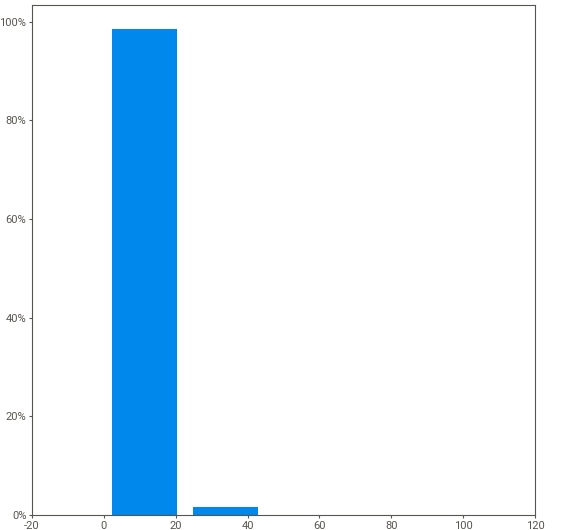
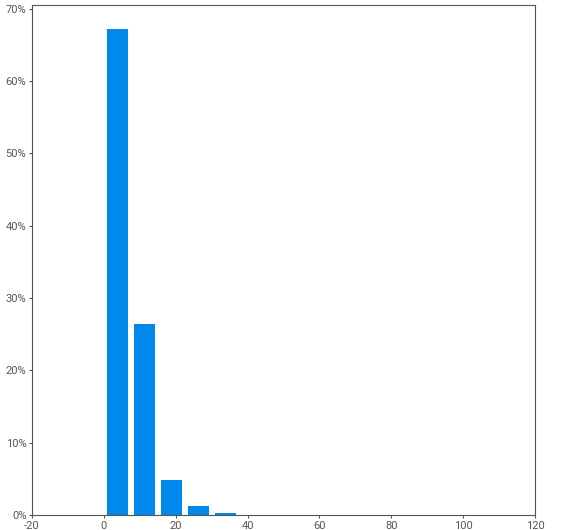
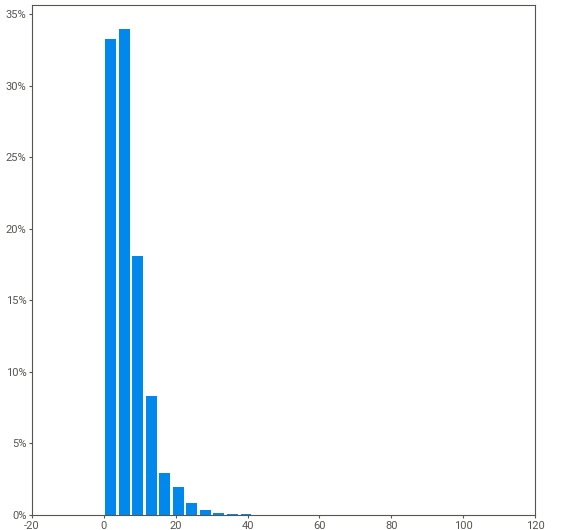
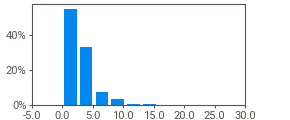
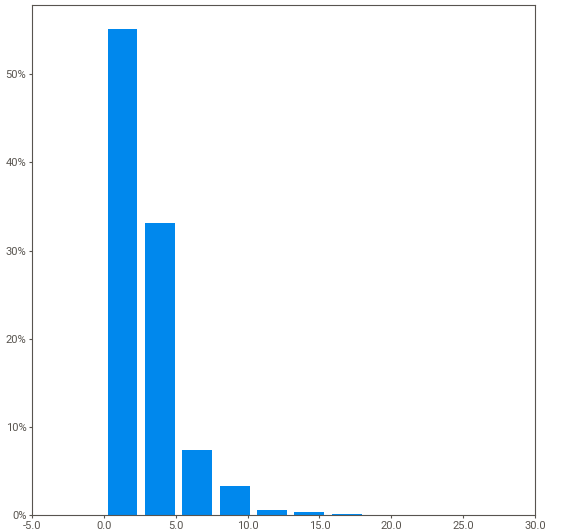
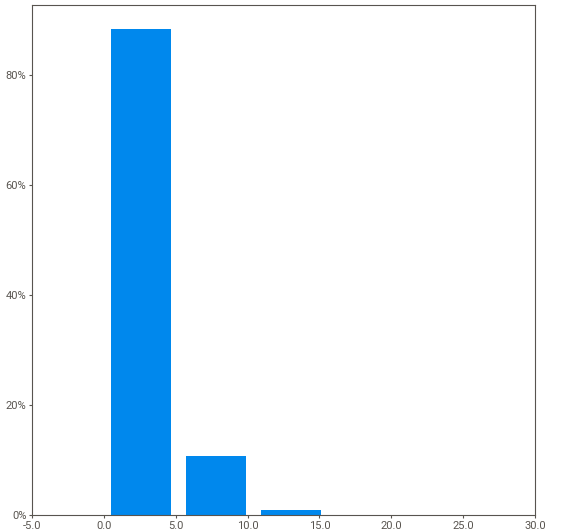
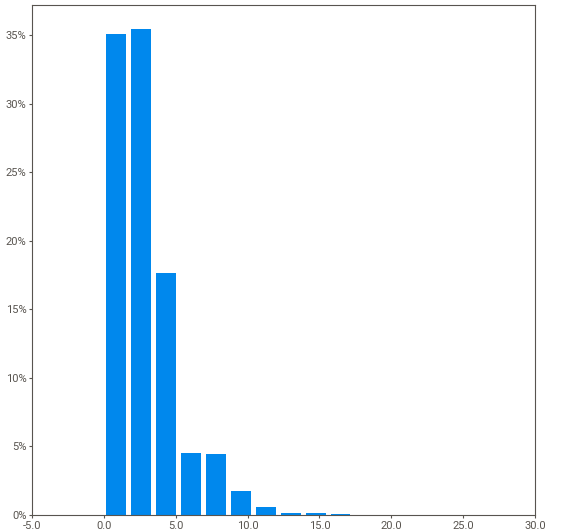
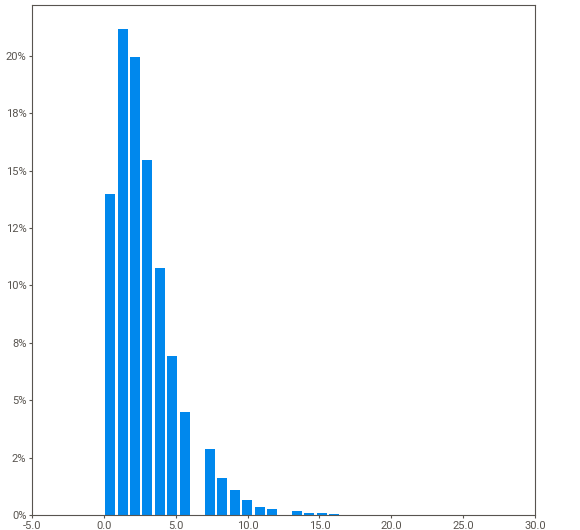
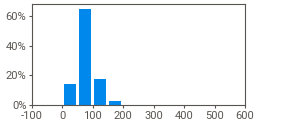
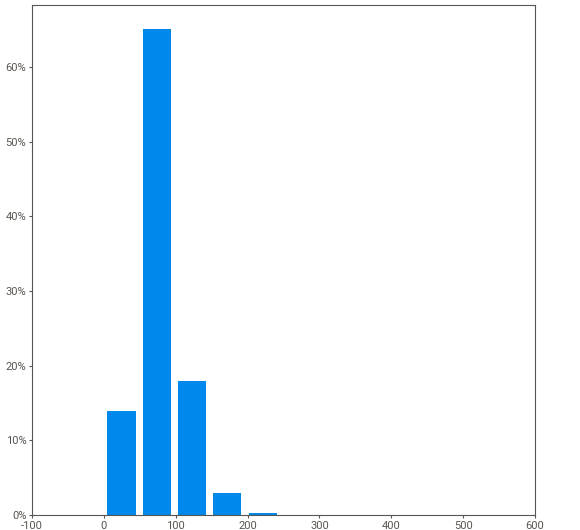
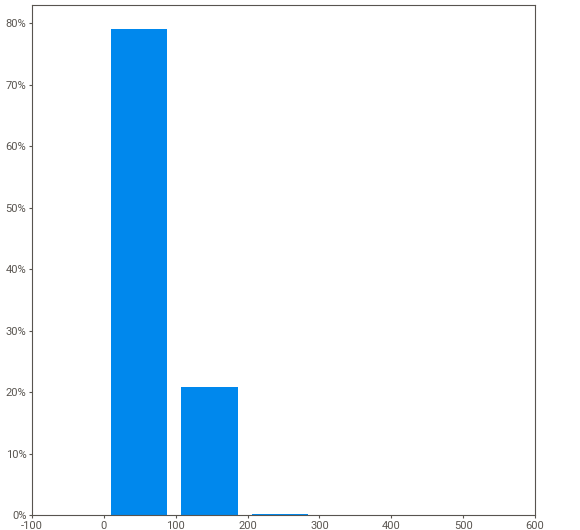
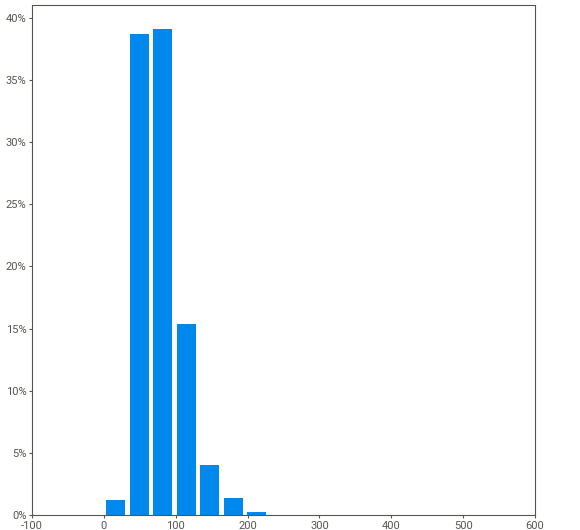
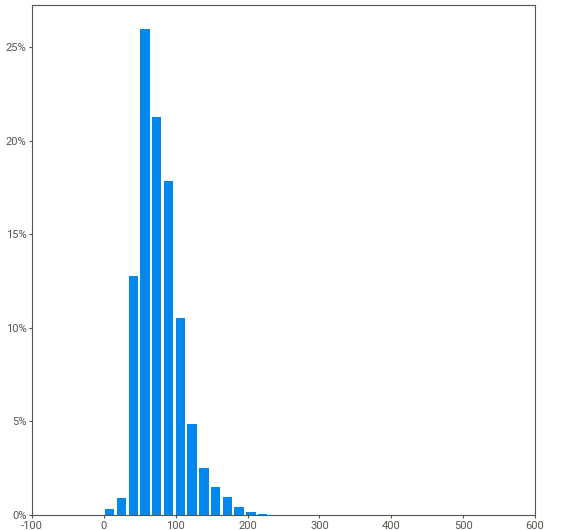
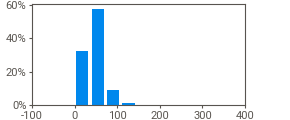
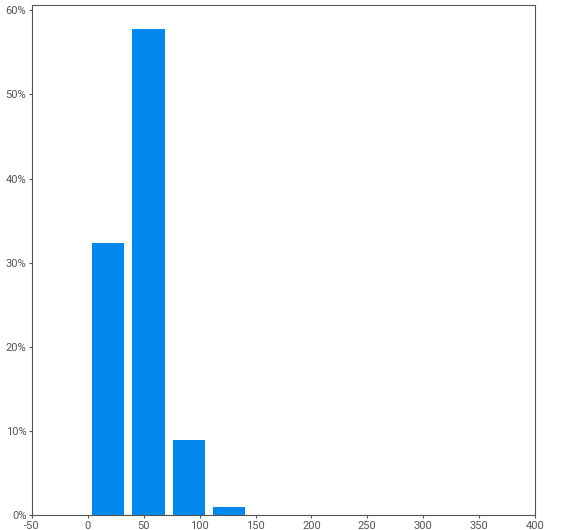
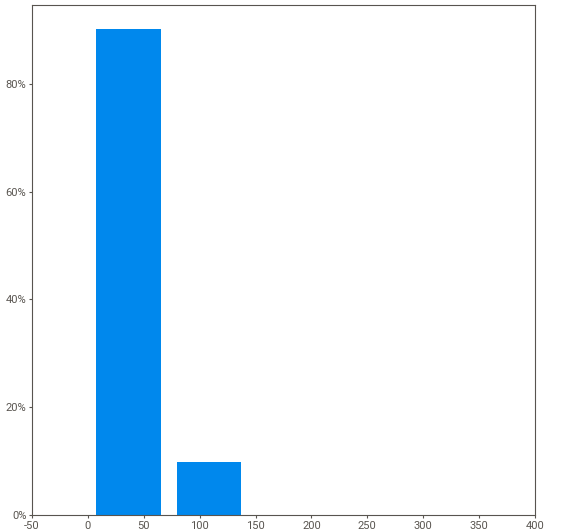
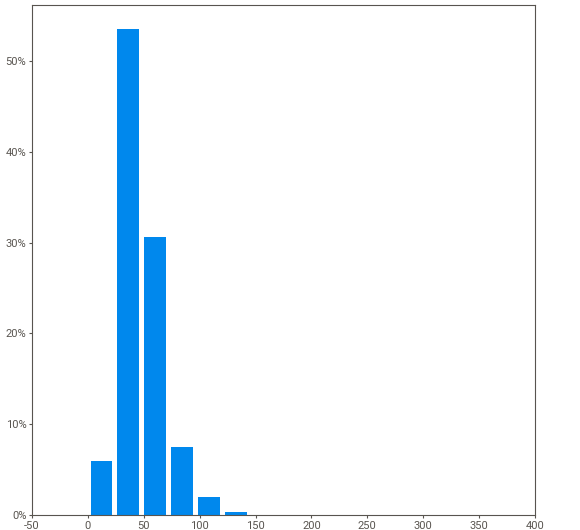
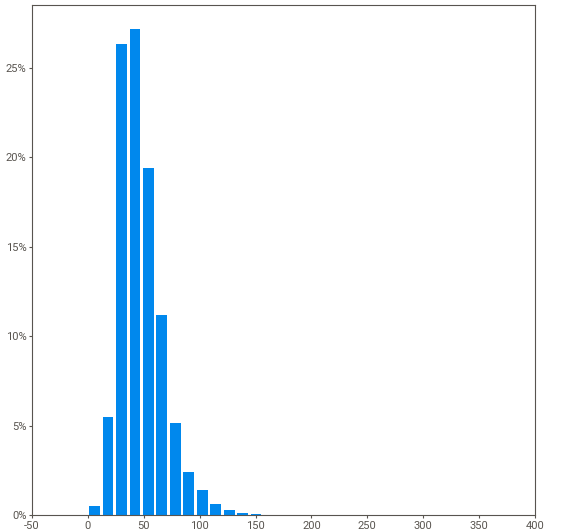
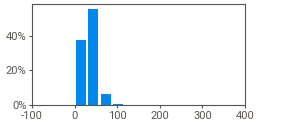
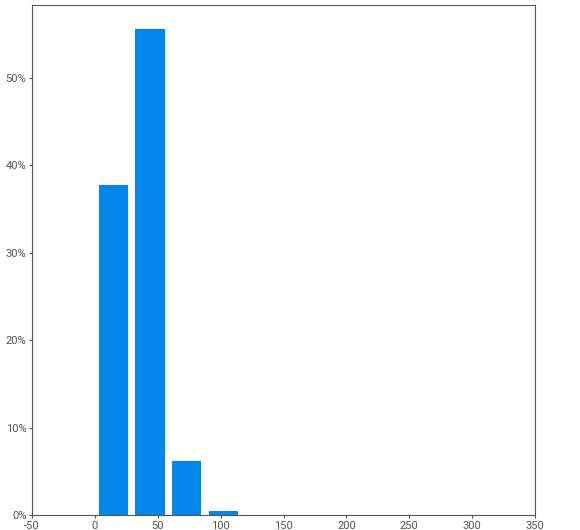
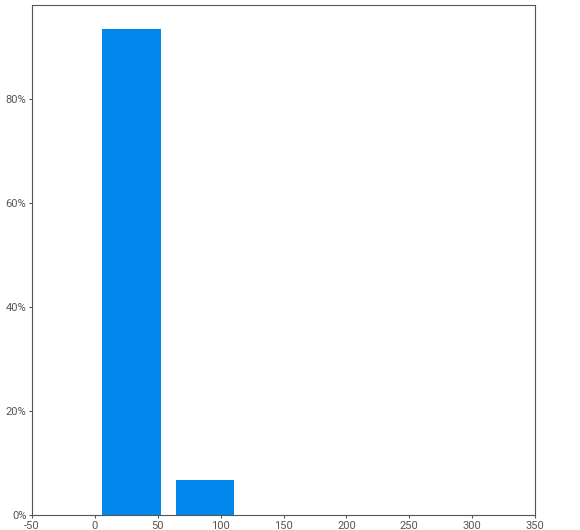
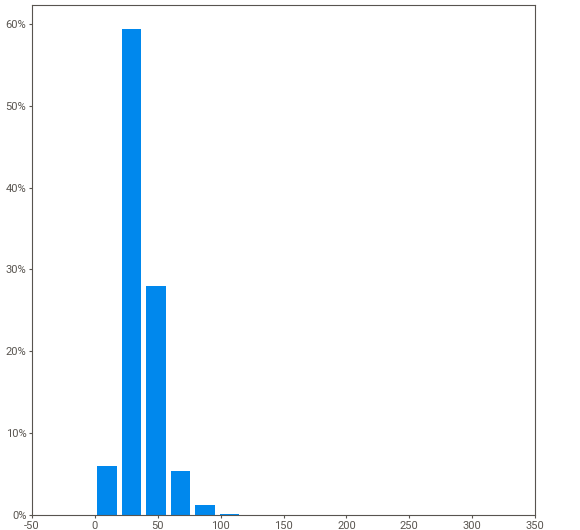
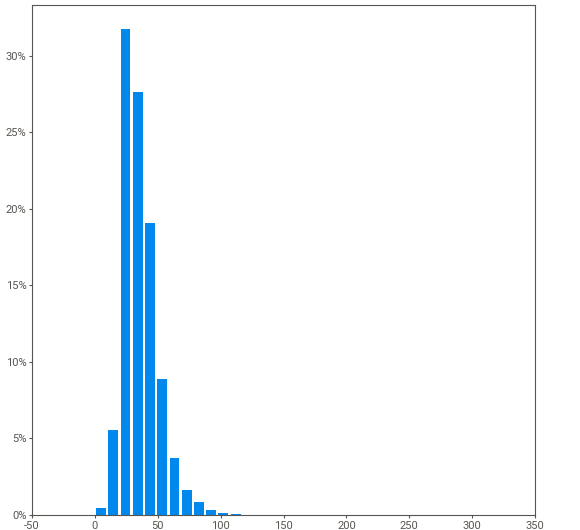
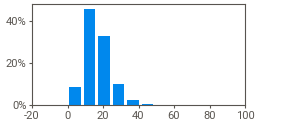
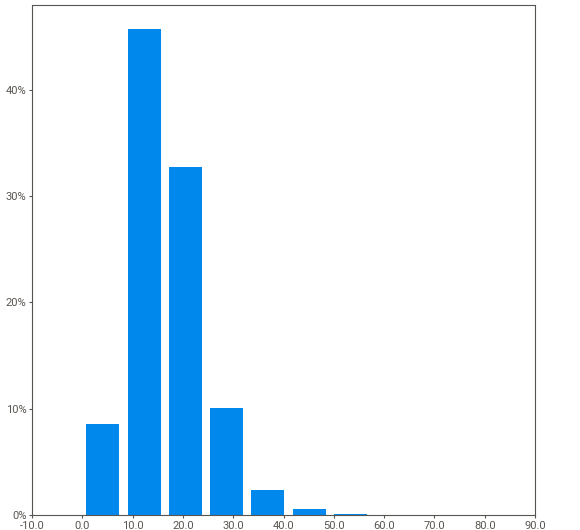
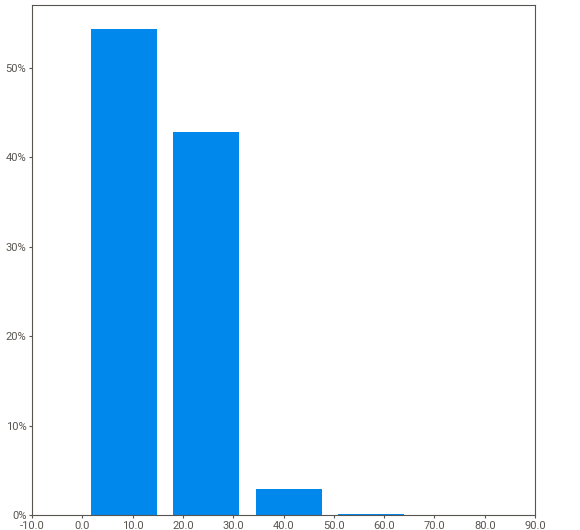
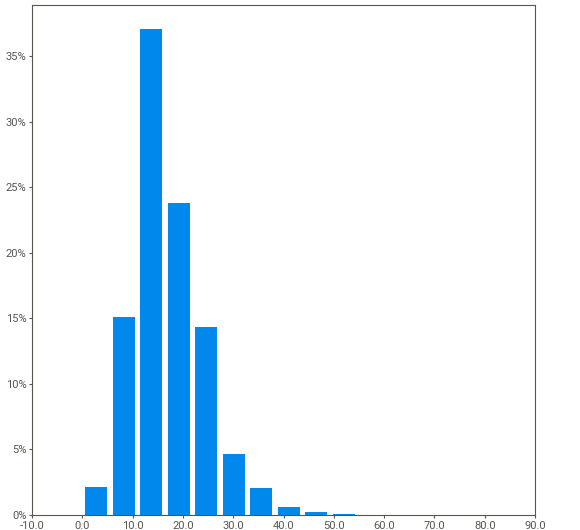
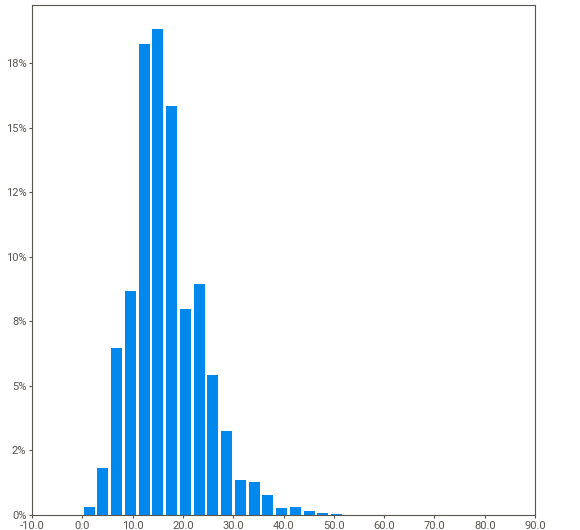
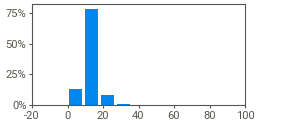
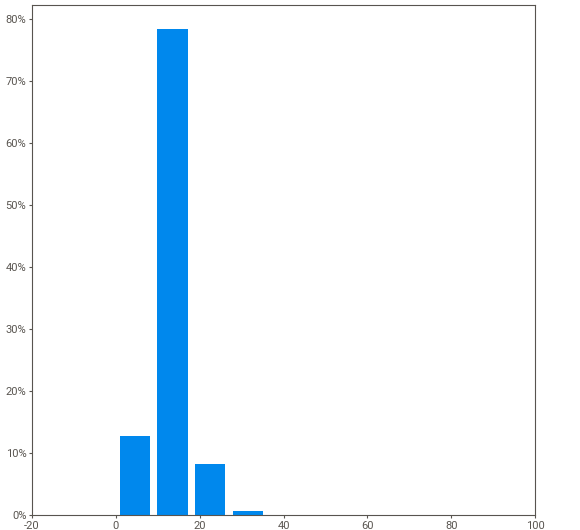
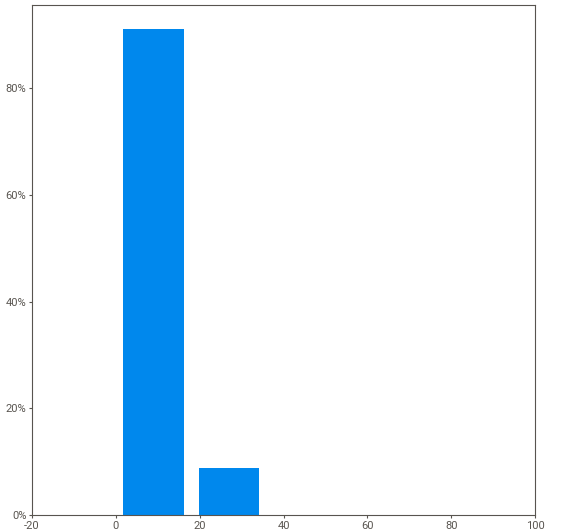
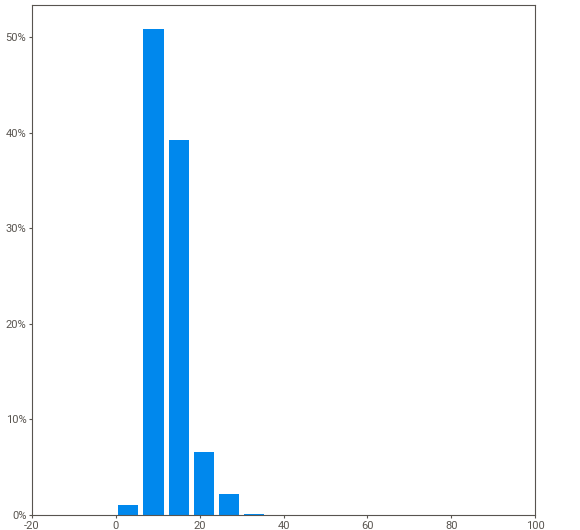
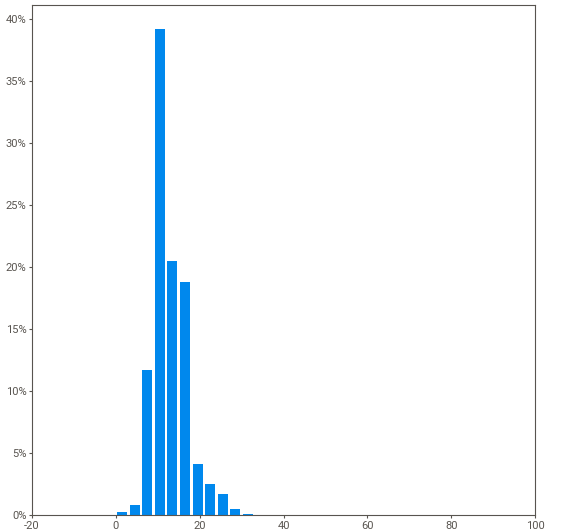
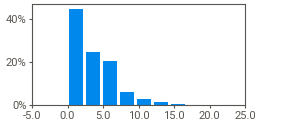
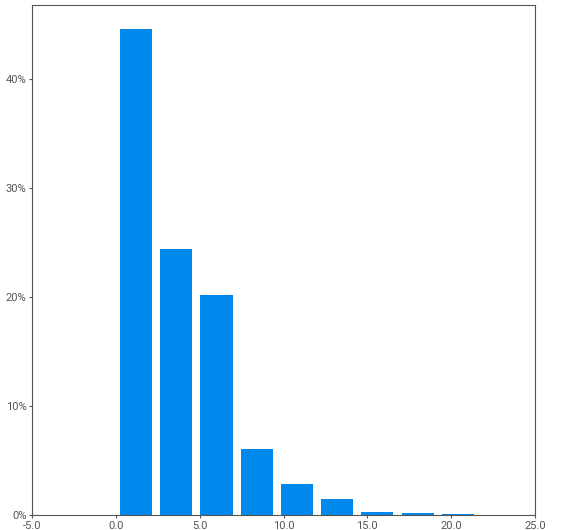
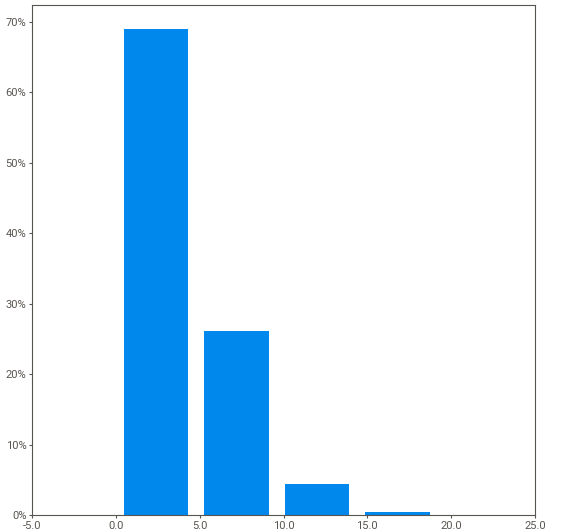
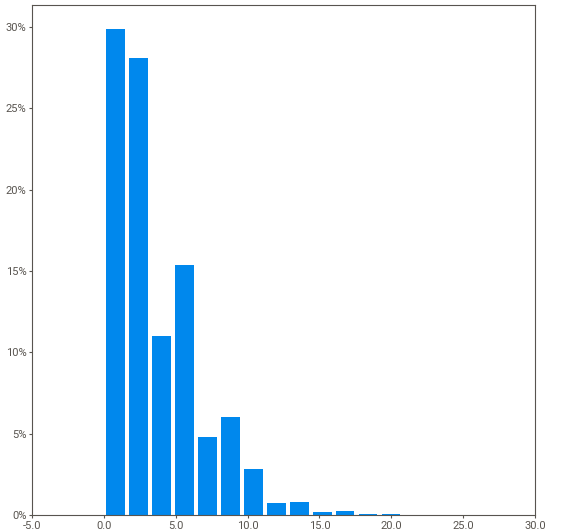
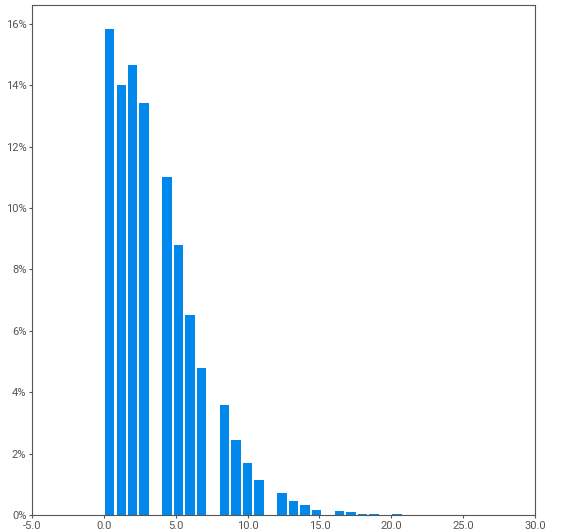
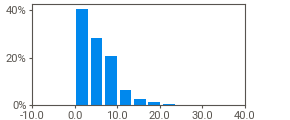
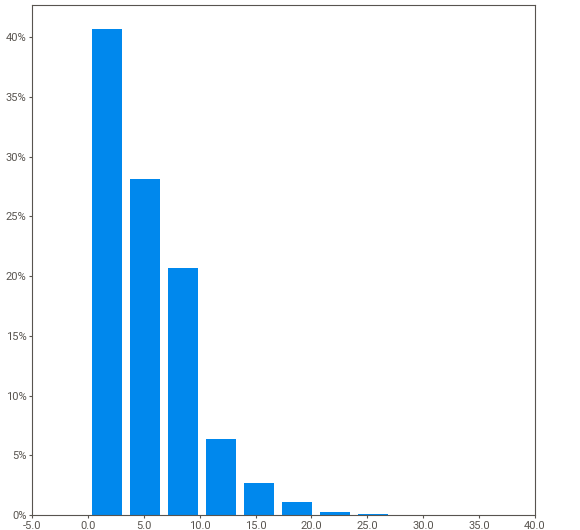
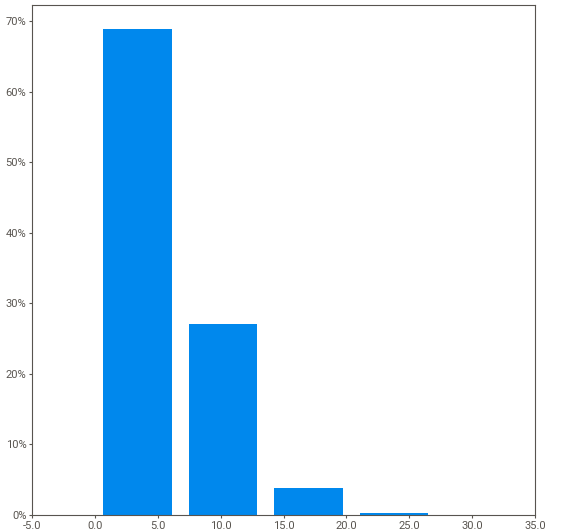
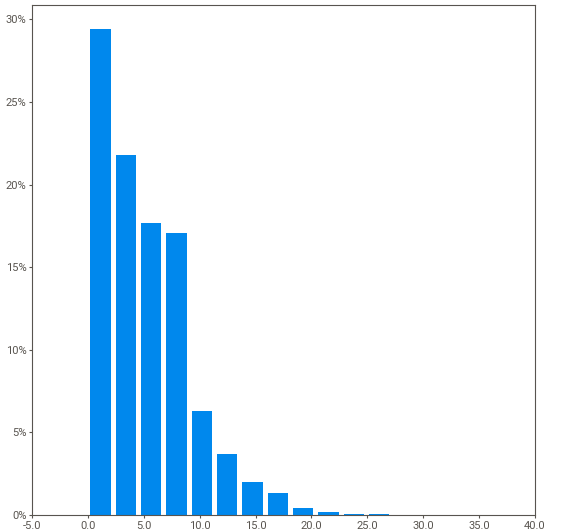
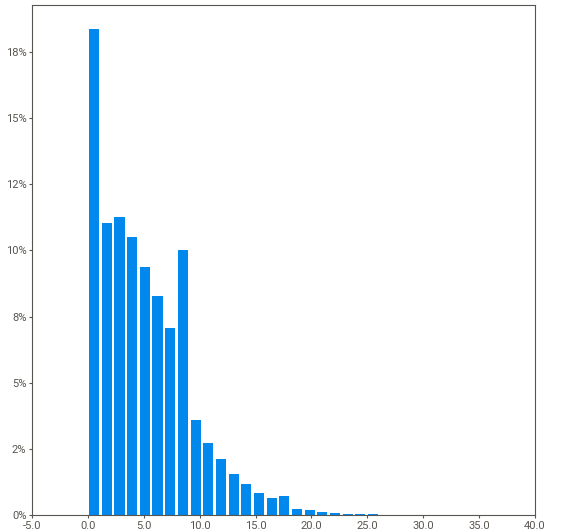
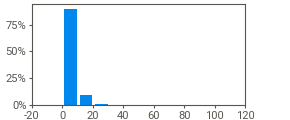
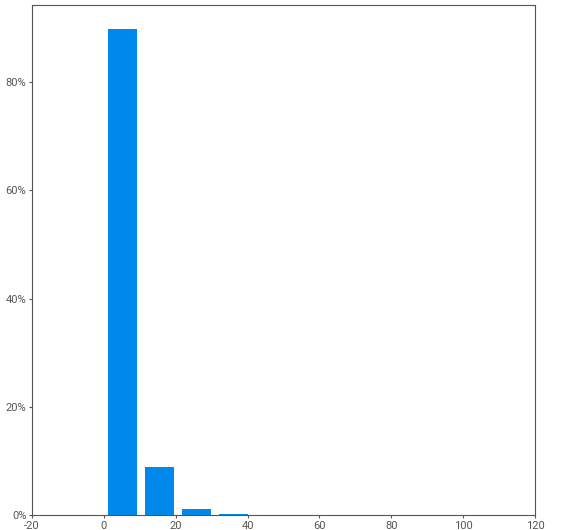
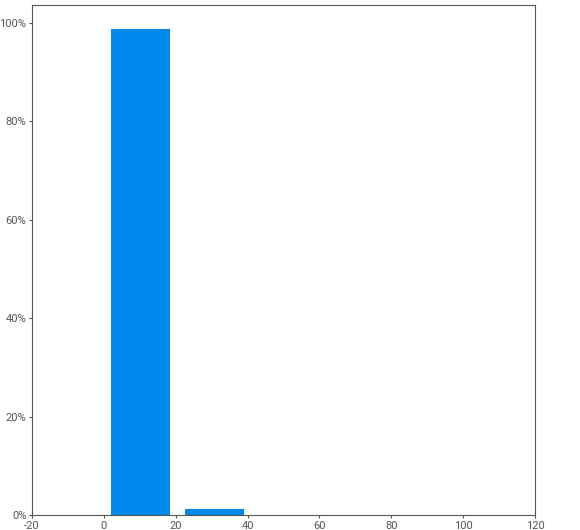
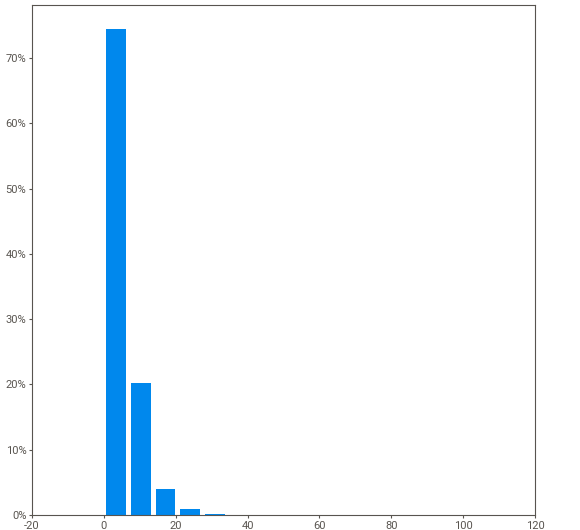
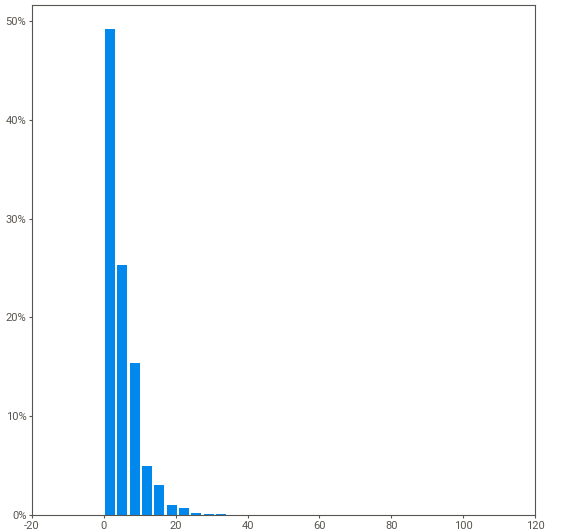
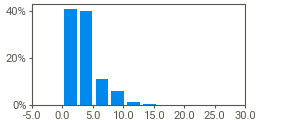
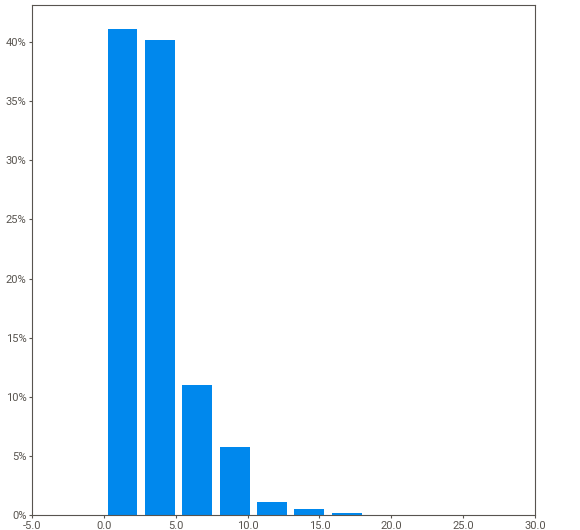
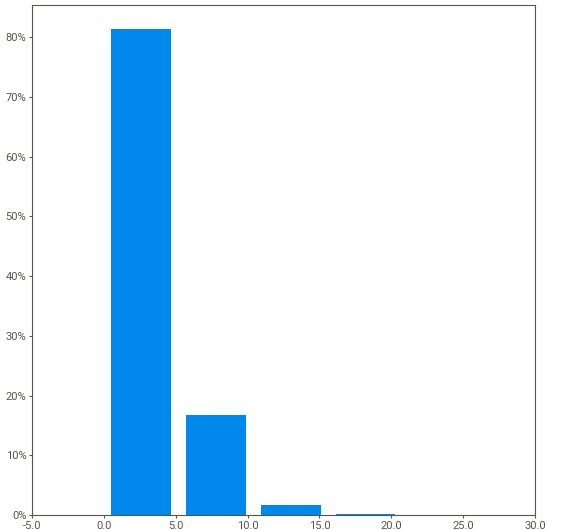
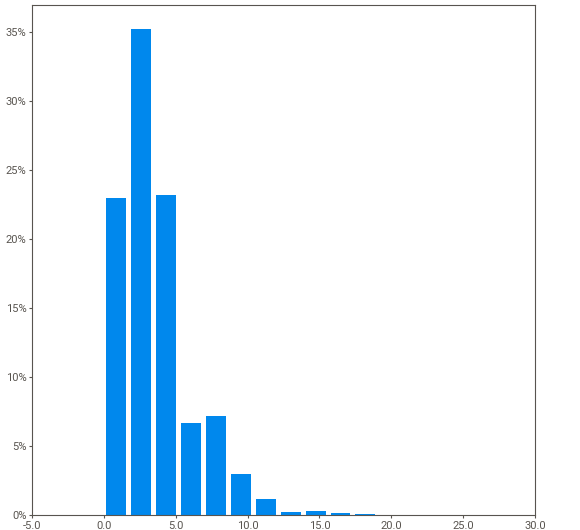
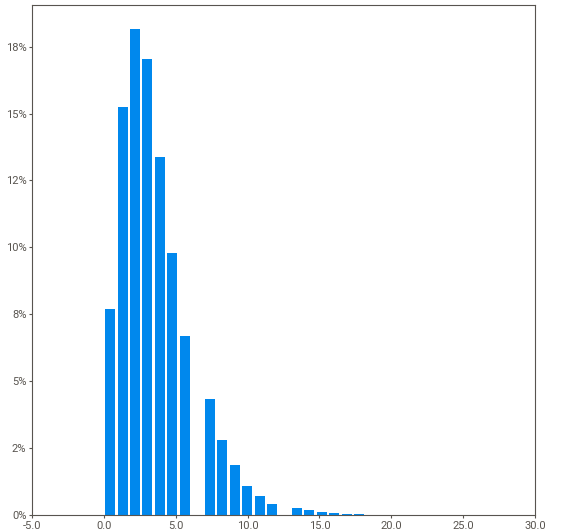
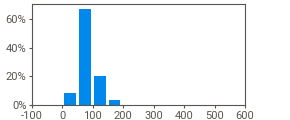
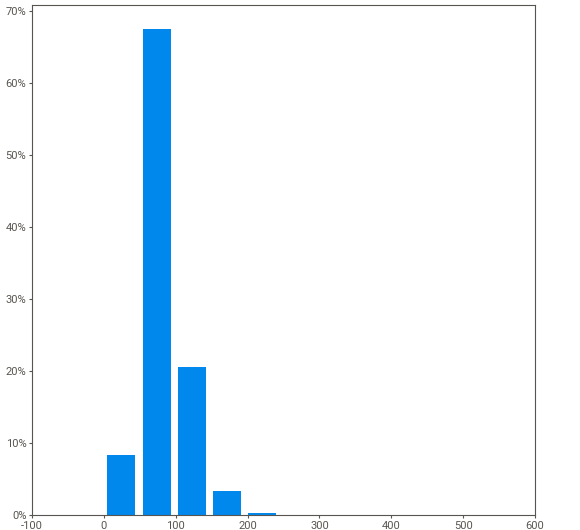
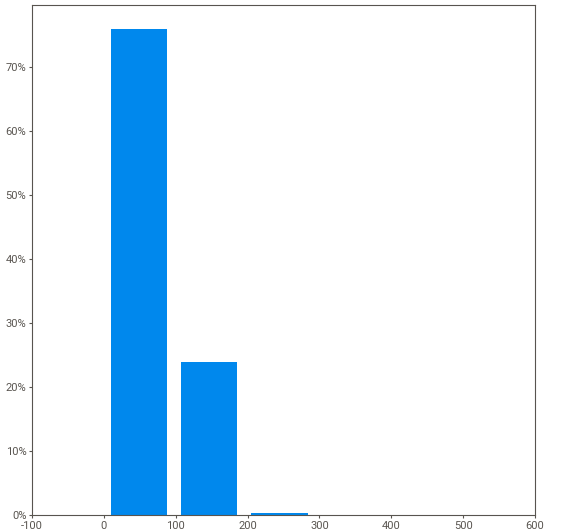
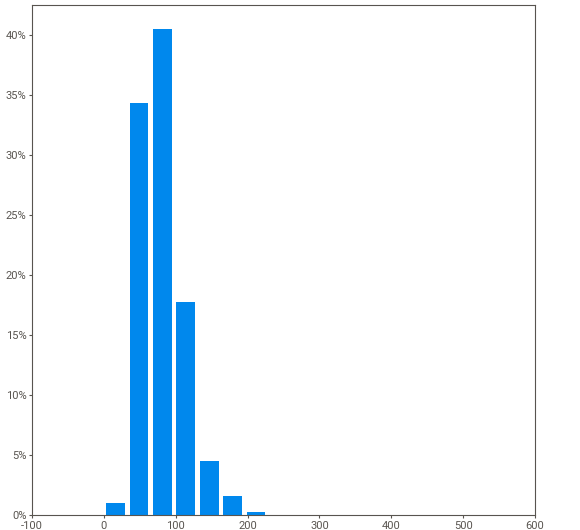
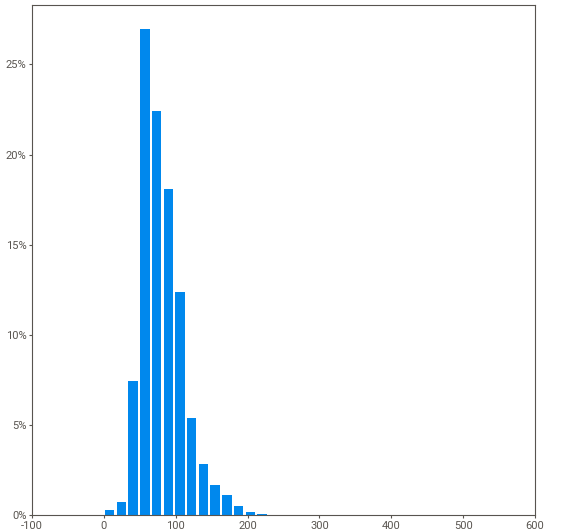
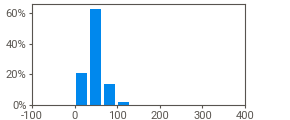
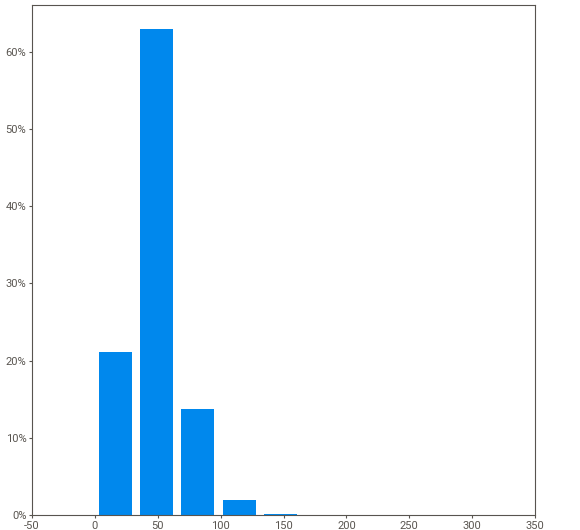
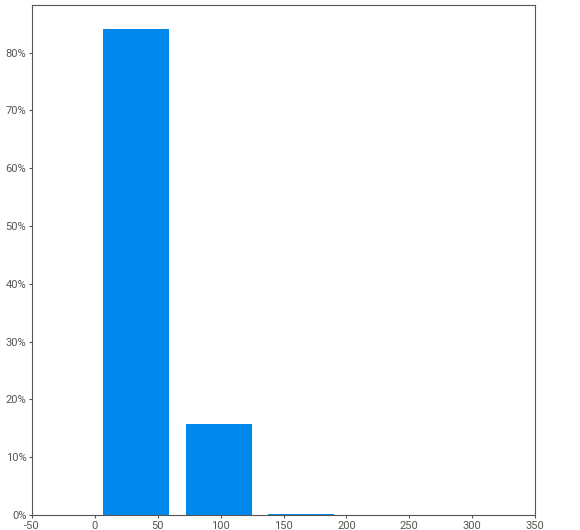
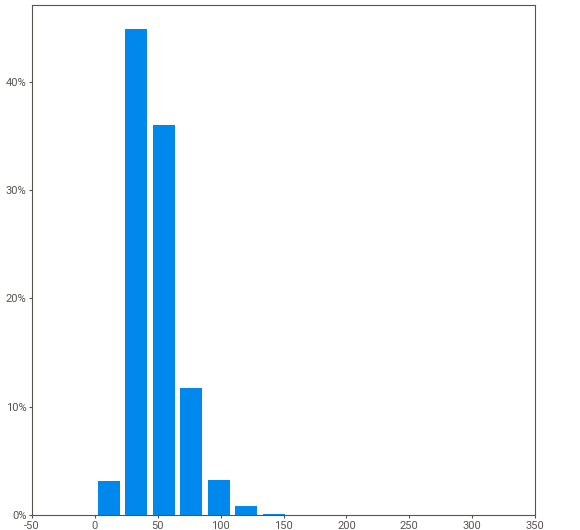
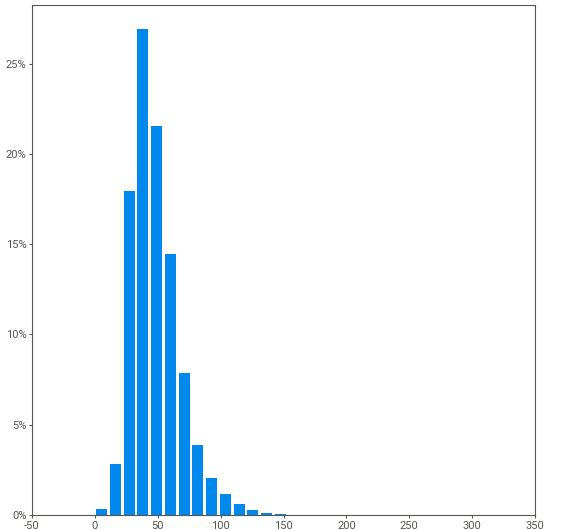
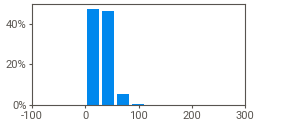
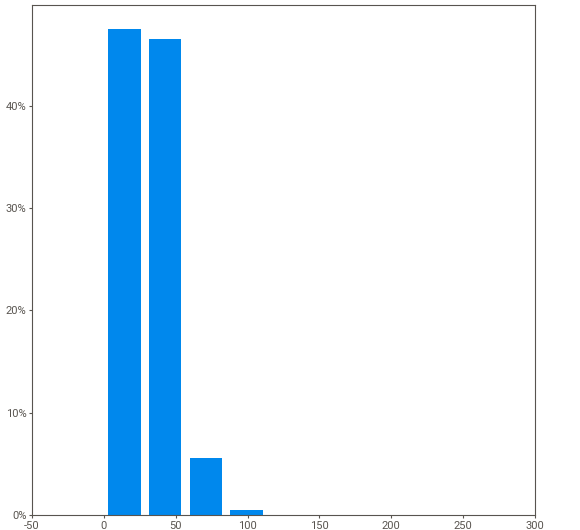
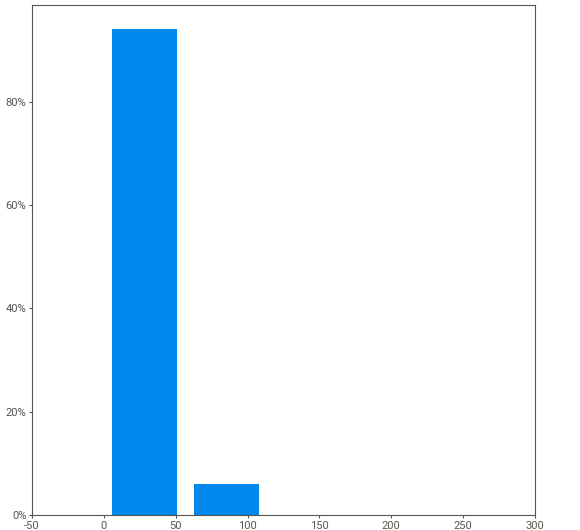
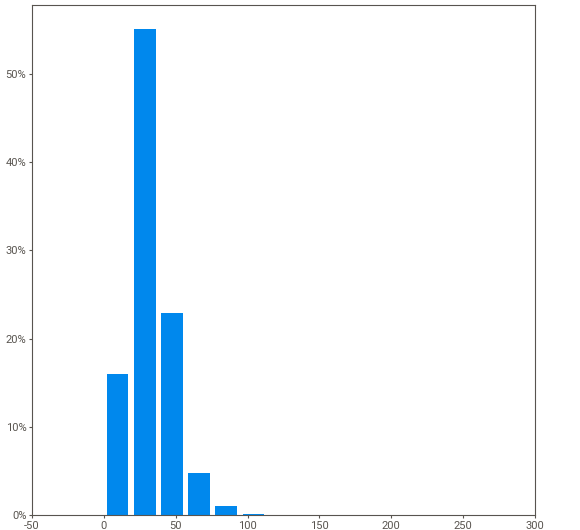
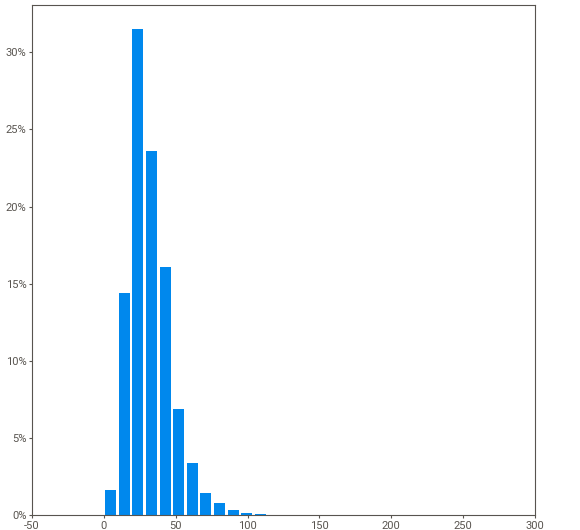
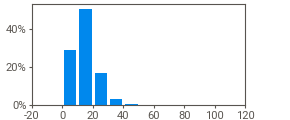
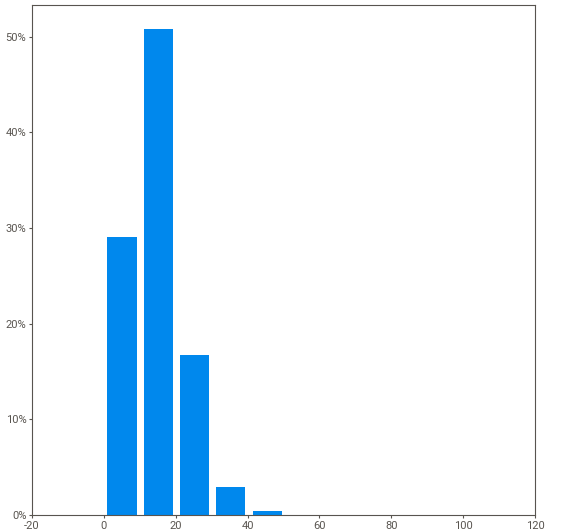
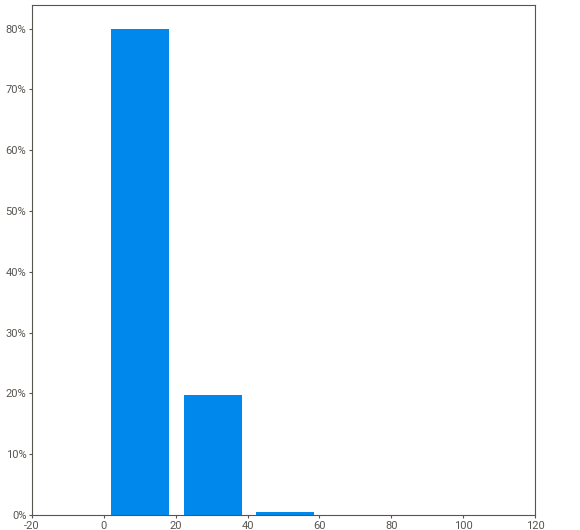
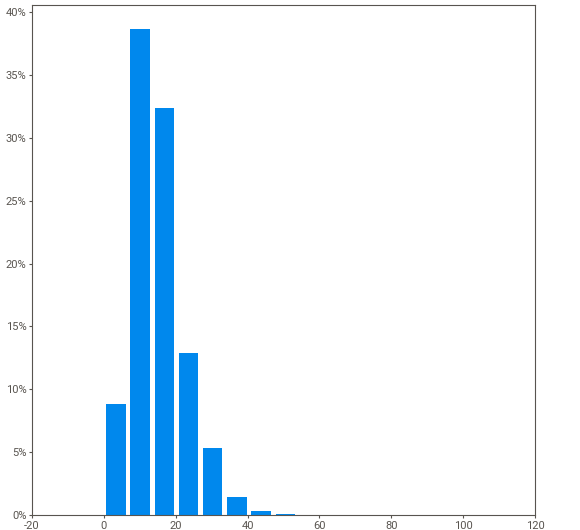
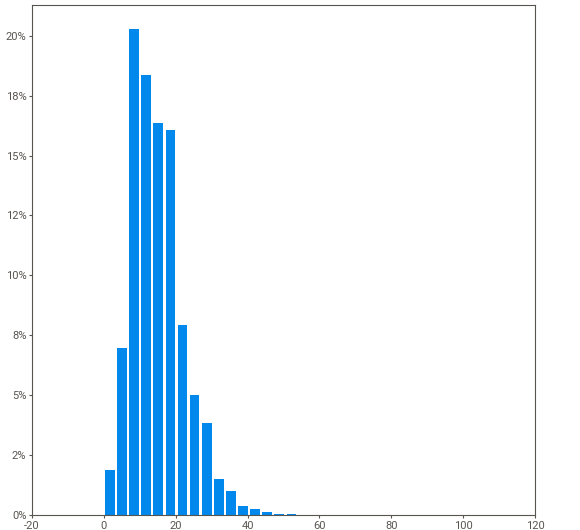
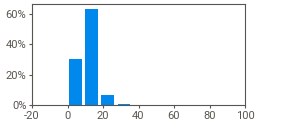
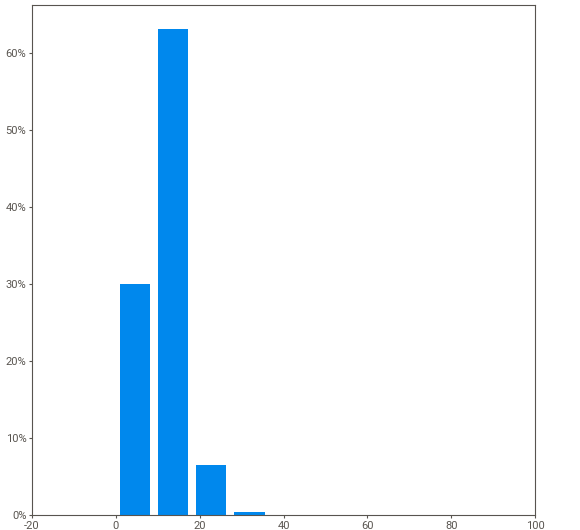
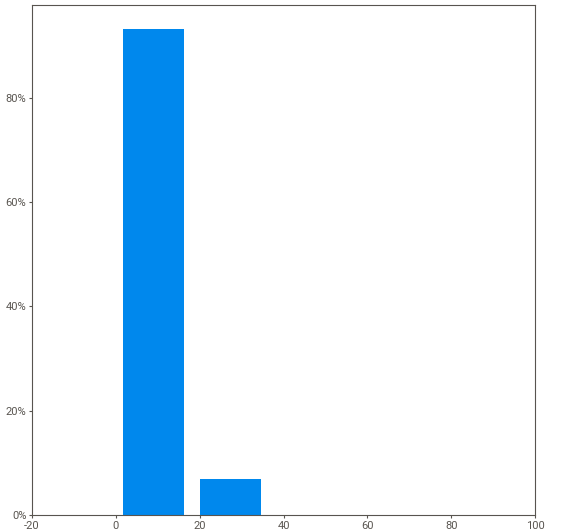
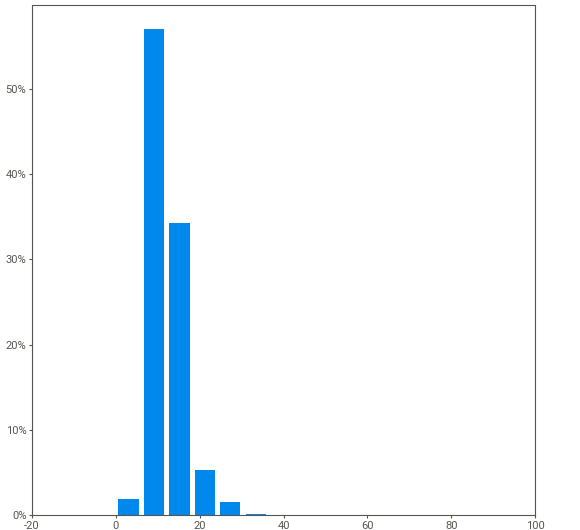
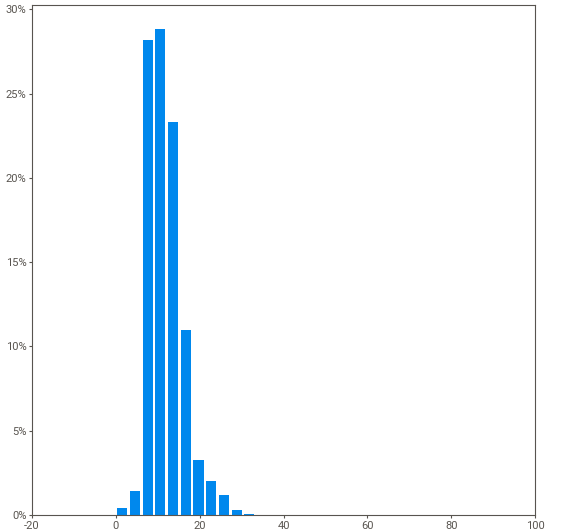
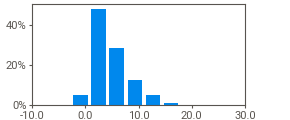
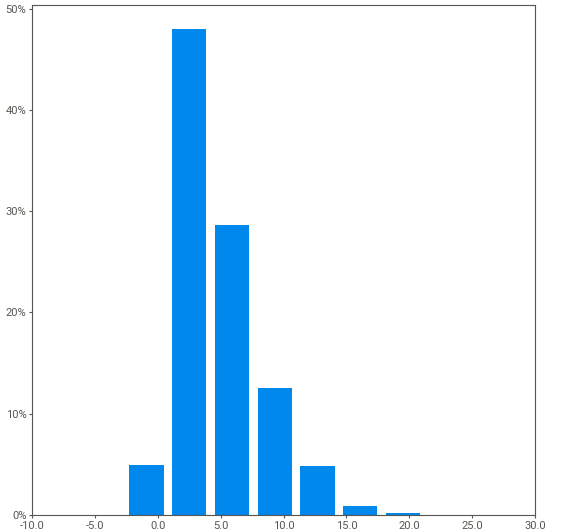
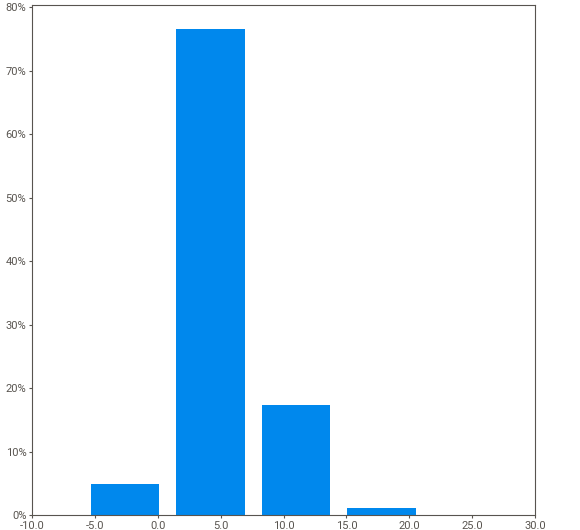
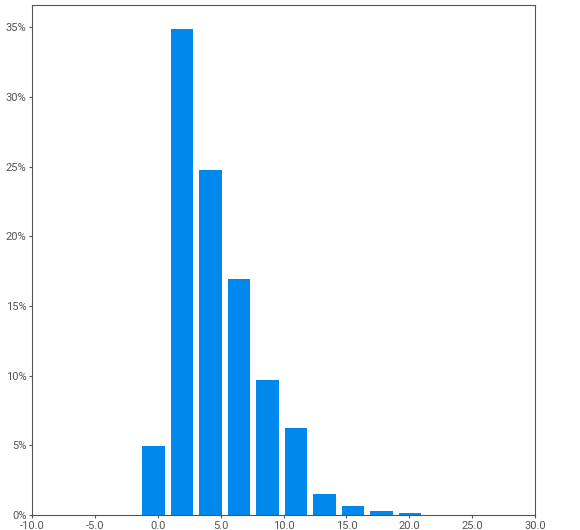
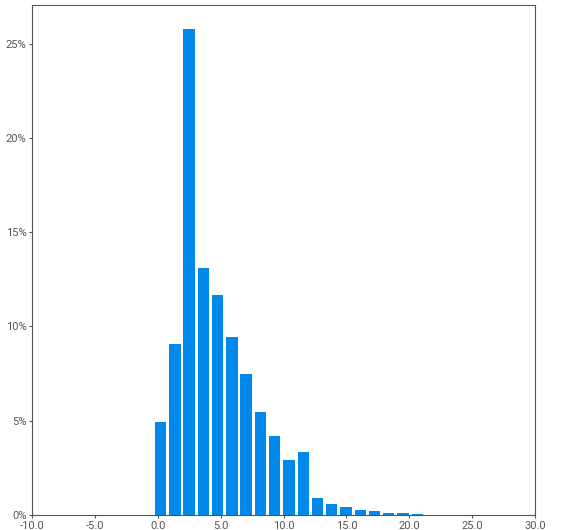
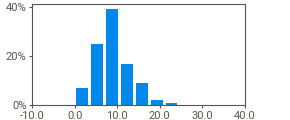
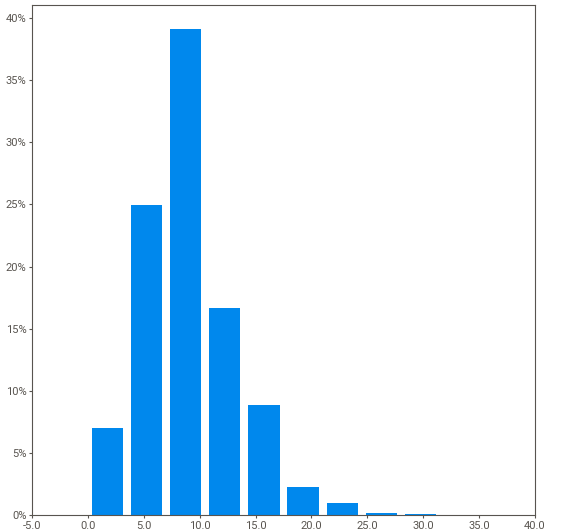
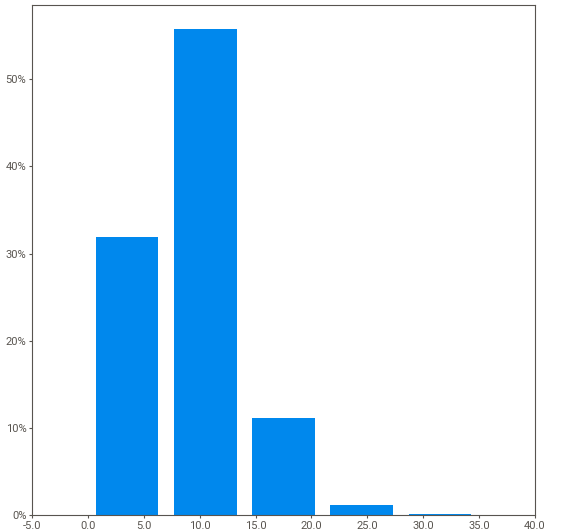
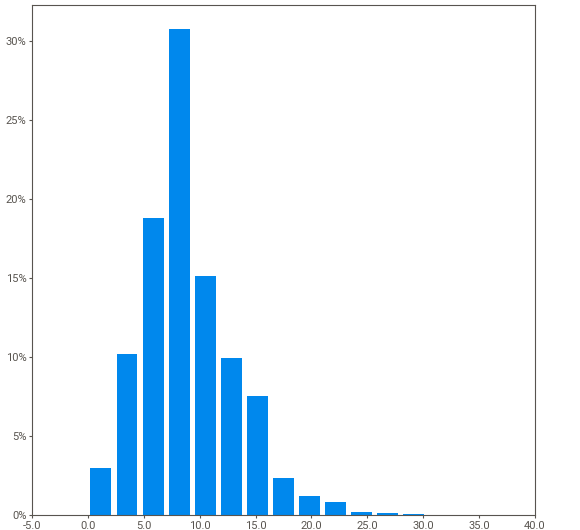
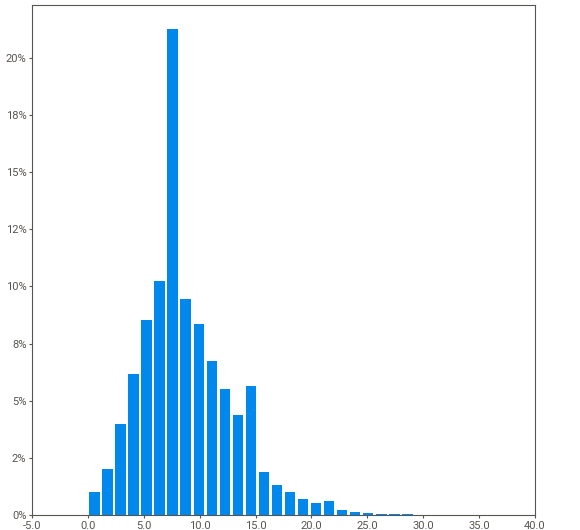
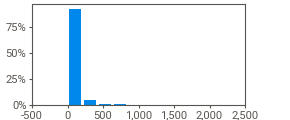
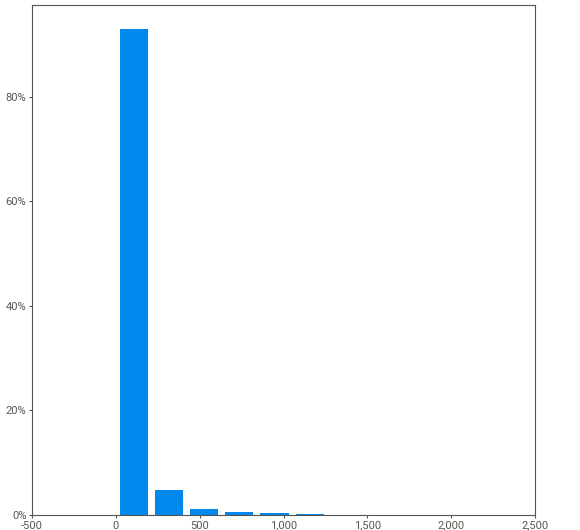
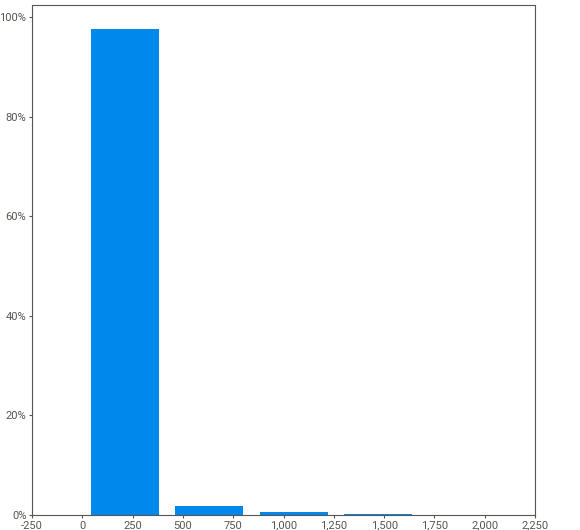
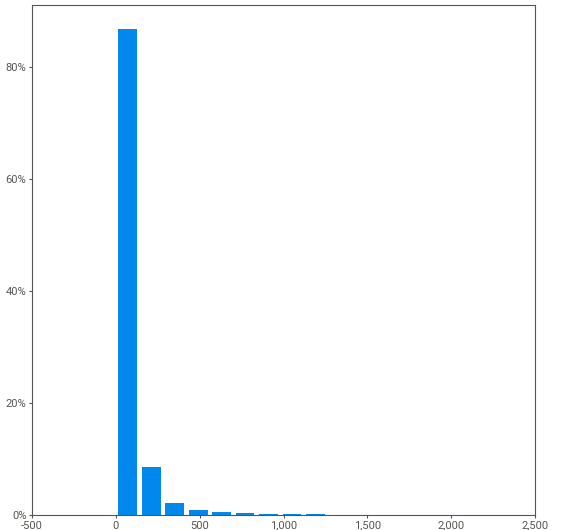
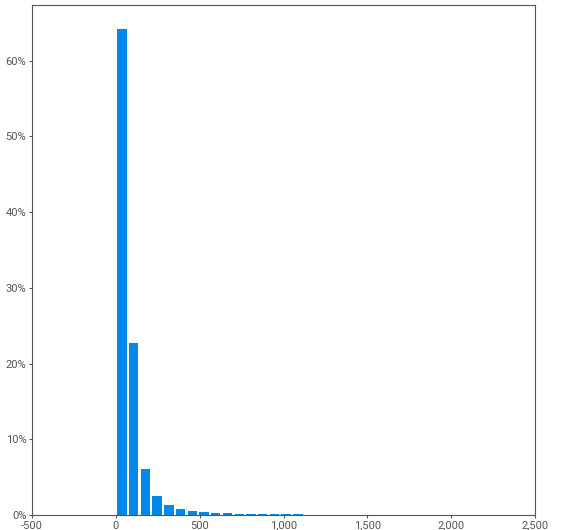
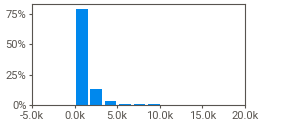
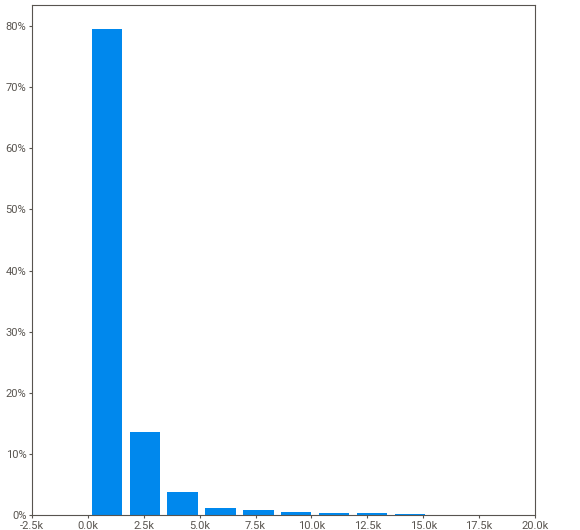
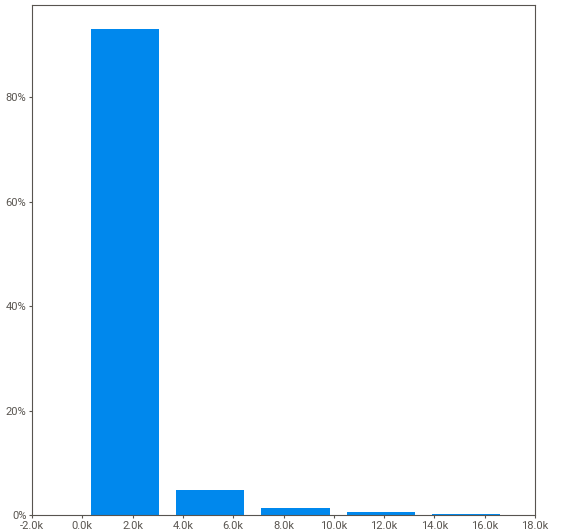
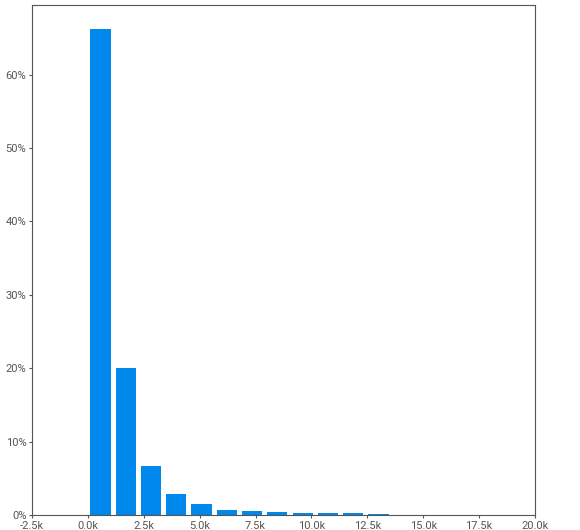
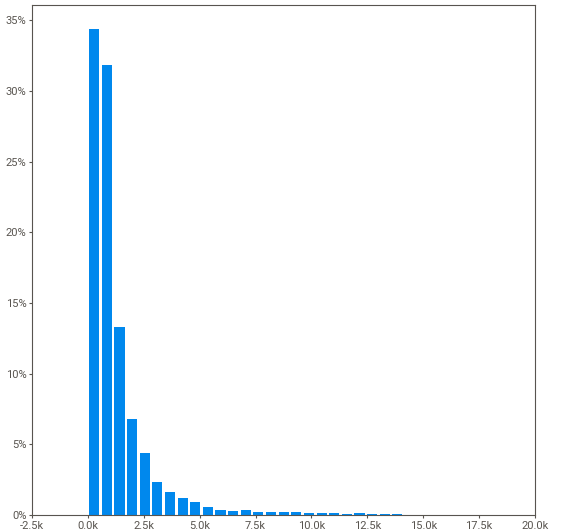
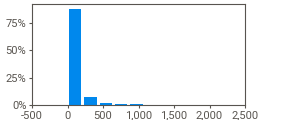
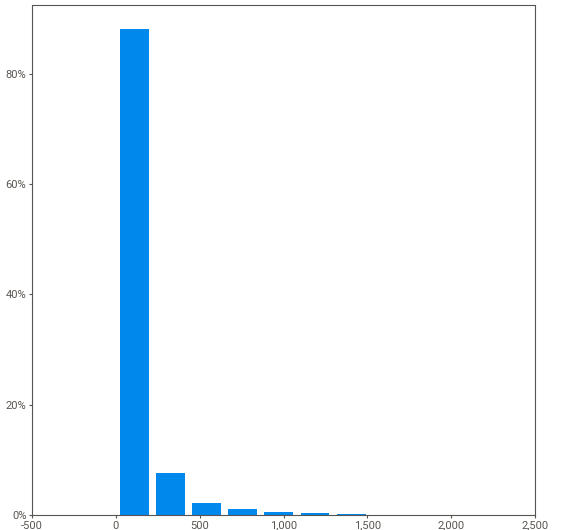
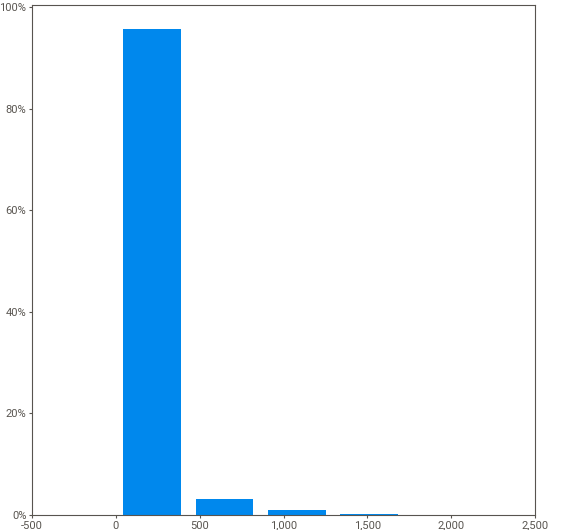
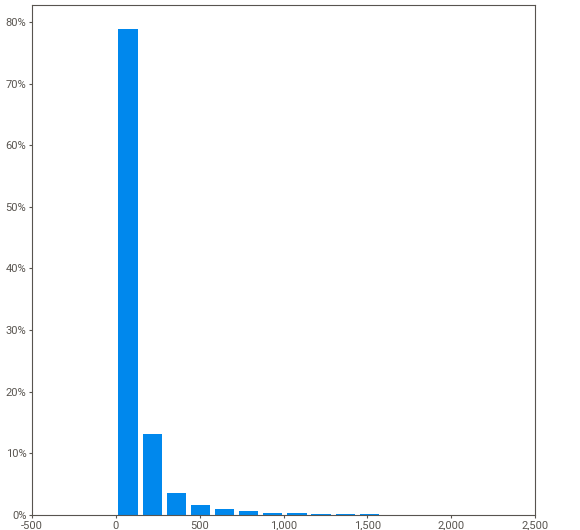
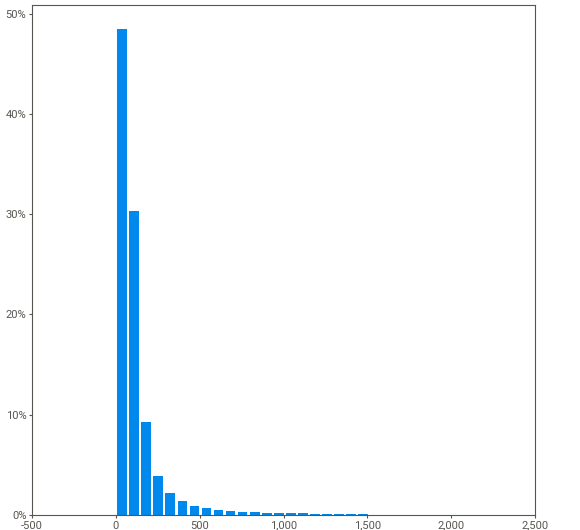
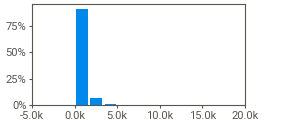
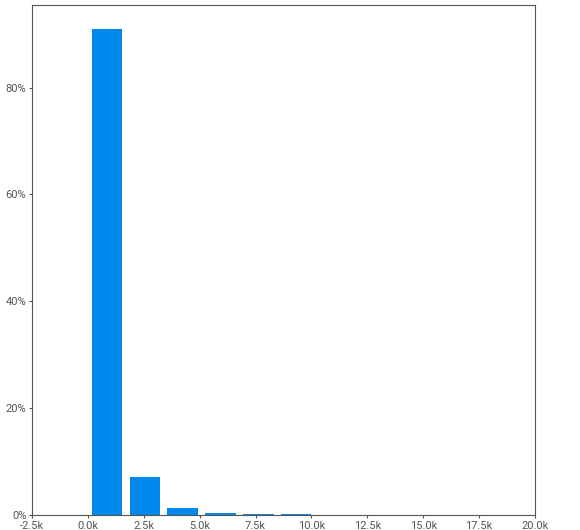
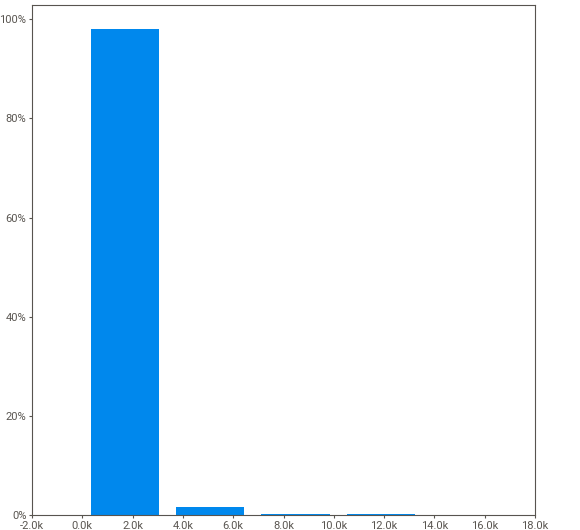
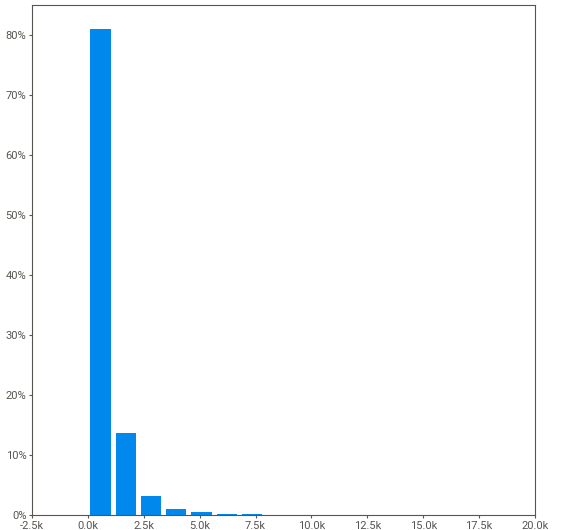
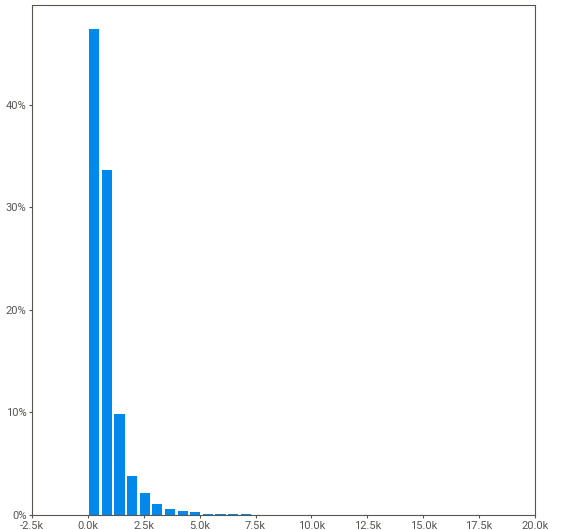
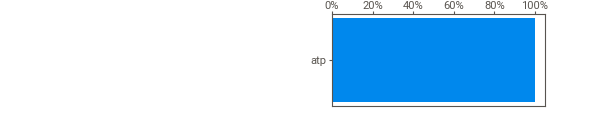
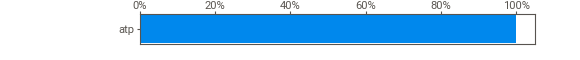
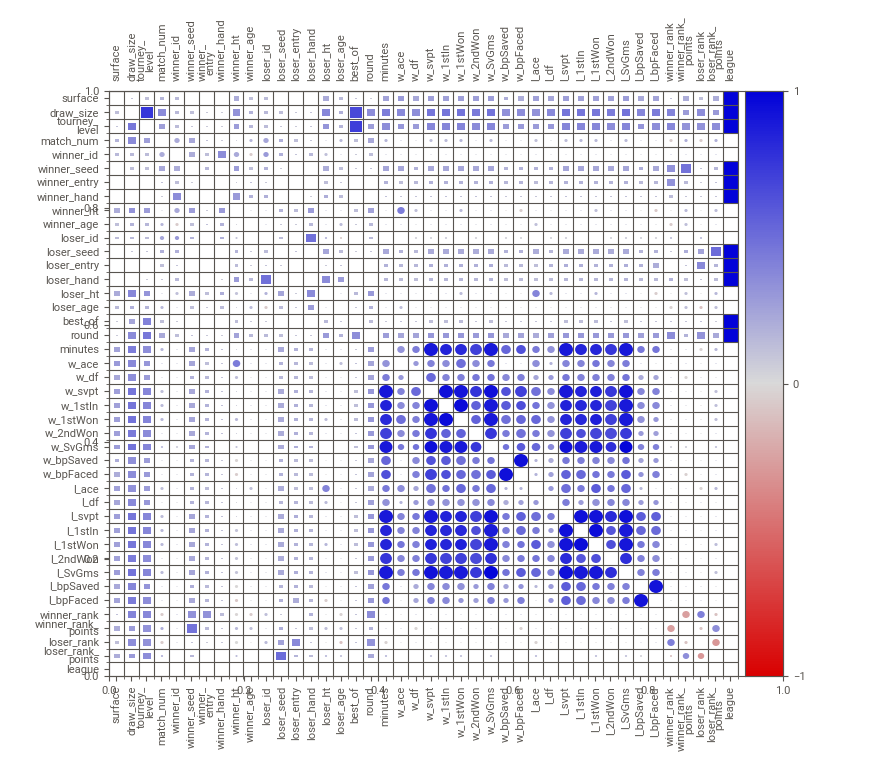
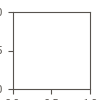

In [43]:
report = sv.analyze(filtered_df)
report.show_notebook() 

What features do you think we can remove straight away? Why? Which should we transform for modeling purposes?

- We can safely drop the column `league` since we have filtered the data to only contain data from the ATP
- Any feature that corresponds to an `id` will not help us do any modeling e.g `tourney_id`, `loser_id`,`winner_id`, `match_num`
- We also won't user player names in our modeling i.e `winner_name`,`loser_name`
- Ranking-related variables i.e `winner_seed`, `winner_entry`, `loser_seed`,`loser_entry` might have been useful predictors but given the amount of missing values in them and the difficulty of imputing them, they also won't be used for modeling
- `winner_rank_points` and `loser_rank_points` help us define the outcome of our classification (the winner gains more ranking points). `winner_rank` and `loser_rank` are redundant.
- `winner_ioc`, `tourney_name` are also not predictive variables, nor are `minutes` or `score` or `draw_size`
  
Now that's out of the way, let's look at missing values in more details.

<Axes: >

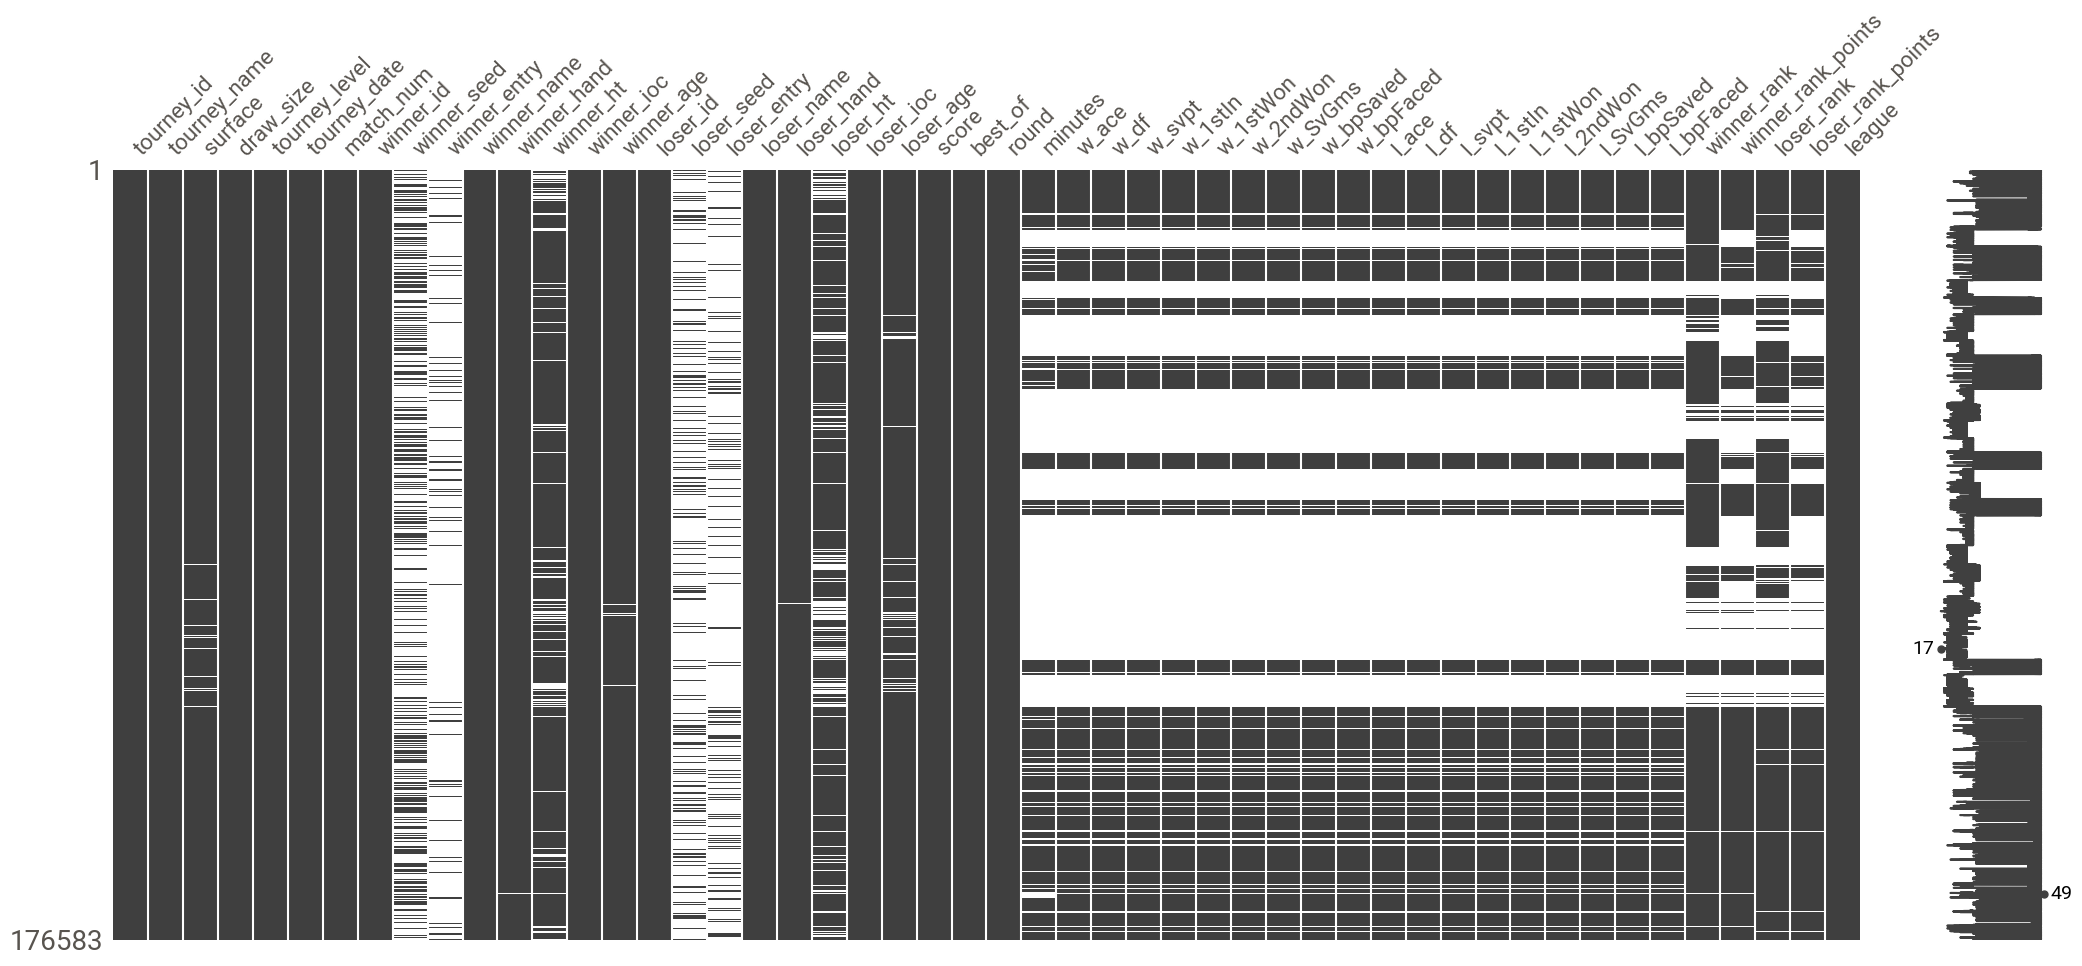

In [59]:
msno.matrix(filtered_df)

How do we explain this pattern?

That's because data entry has systematically not been done for some matches, in particular Davis Cup matches. 

In [60]:
columns_to_check=['minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 
                 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 
                 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']
missing_rows_all = filtered_df[filtered_df[columns_to_check].isna().all(axis=1)]
print(missing_rows_all)

       tourney_id                tourney_name surface draw_size tourney_level  \
39      2019-0451                        Doha    Hard        32             A   
324     2019-7434                       Sofia    Hard        32             A   
491     2019-6932              Rio de Janeiro    Clay        32             A   
534     2019-M004                    Acapulco    Hard        32             A   
612     2019-M006        Indian Wells Masters    Hard       128             M   
...           ...                         ...     ...       ...           ...   
177861   2014-573                    Valencia    Hard        32             A   
177934   2014-605                 Tour Finals    Hard         8             F   
177935  2014-D015  Davis Cup WG F: FRA vs SUI    Clay         4             D   
177936  2014-D015  Davis Cup WG F: FRA vs SUI    Clay         4             D   
177937  2014-D015  Davis Cup WG F: FRA vs SUI    Clay         4             D   

       tourney_date  match_

We'll simply drop all such matches.

In [61]:
filtered_df=filtered_df.dropna(subset=columns_to_check)

We're left with a few cases where `loser_age` or `loser_hand` are missing (those can safely be dropped) or slightly trickier cases where `loser_ht` and `winner_ht` are missing (we can either impute, drop or not use these variables for predictions - given the overall low proportion of such cases, we'll drop those rows.)

In [62]:
filtered_df = filtered_df.dropna(subset=['loser_hand','loser_age','winner_ht','loser_ht'],how='any')

<Axes: >

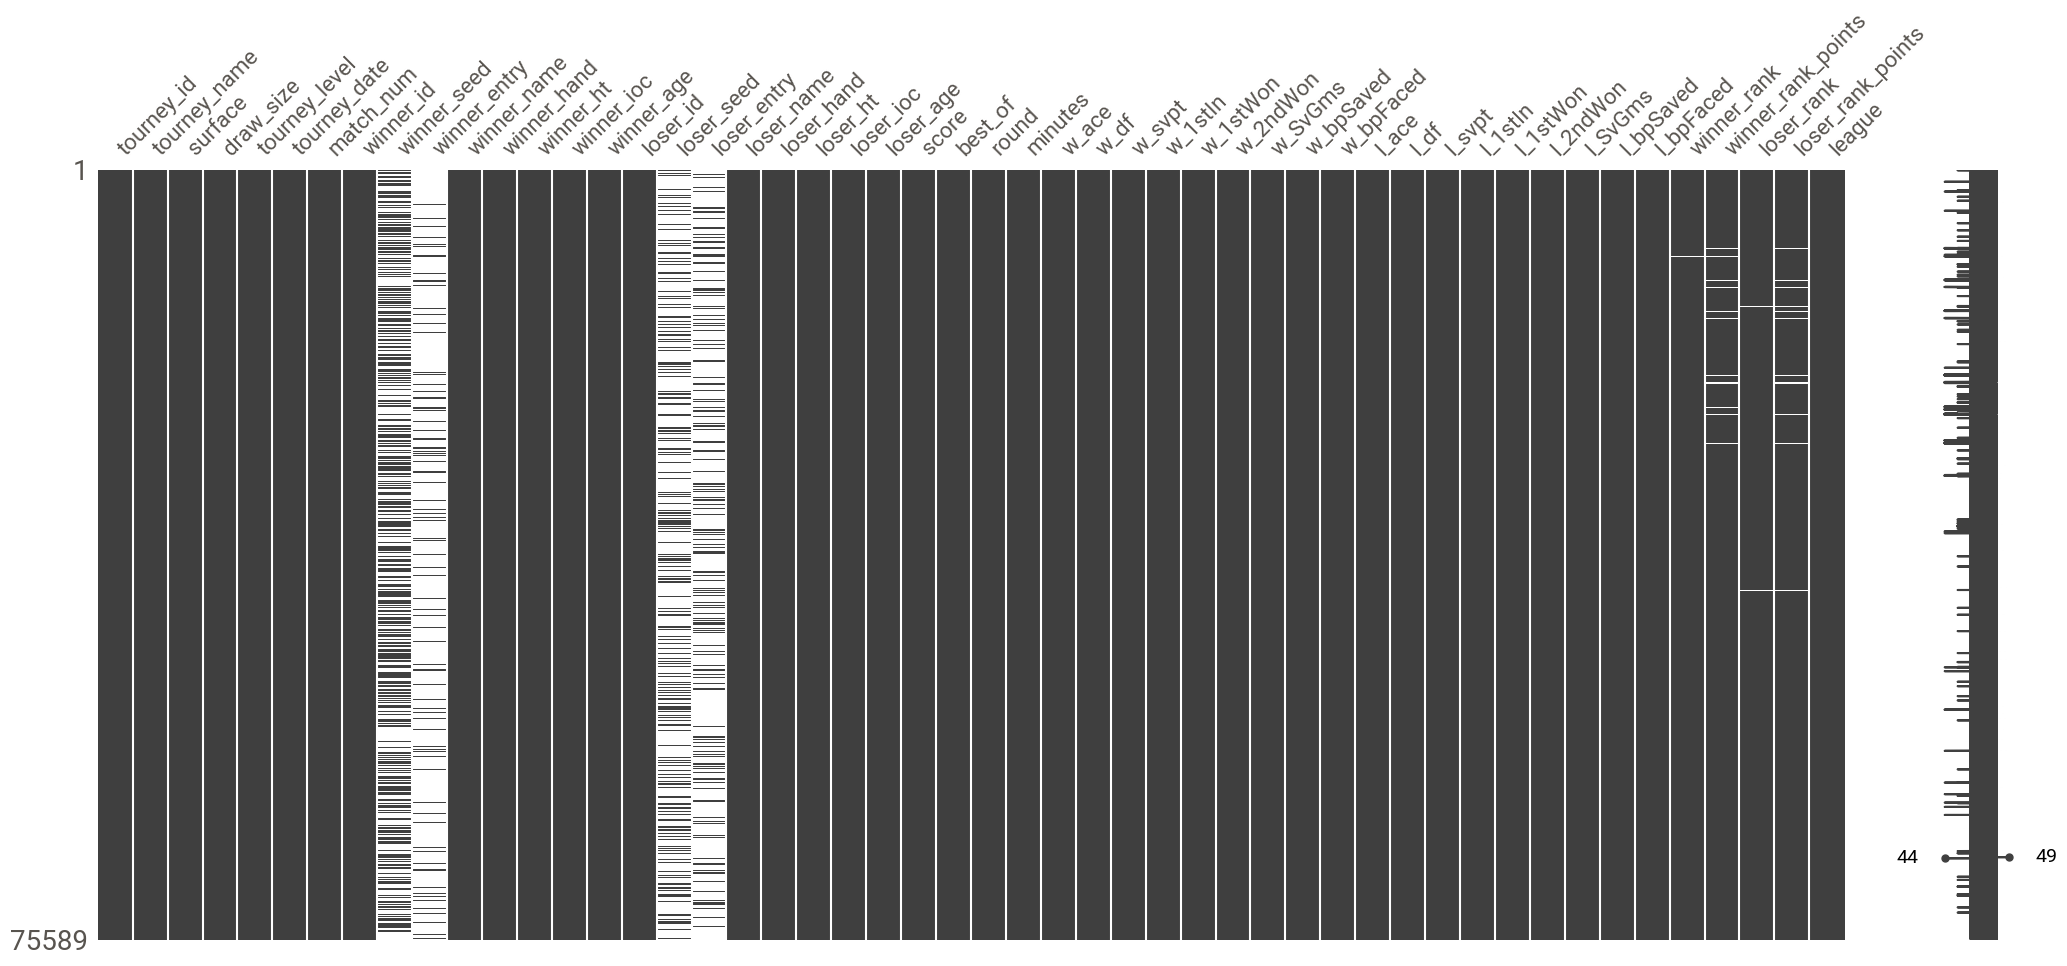

In [63]:
msno.matrix(filtered_df)


We need to clean up our dataset (i.e remove redundant variables):

In [64]:
# a bit of clean-up (note that we retained some variables such as tourney_name or player_name for ease of interpretation later on)
filtered_df=filtered_df.drop(columns=['winner_seed','winner_entry','tourney_id','draw_size','loser_ioc','tourney_level','match_num','loser_id','loser_seed','loser_entry','minutes','league','winner_id','winner_ioc'])

We also convert our categorical variables into numerical variables using `scikit-learn LabelEncoder`:

In [65]:
categorical_cols = ['surface', 'winner_hand', 'loser_hand']
for col in categorical_cols:
    encoder = LabelEncoder()
    filtered_df[col] = encoder.fit_transform(filtered_df[col])

And we then scale (i.e standardise) our numerical variables (except ranking-related ones which are not used for modeling!)^[note that there is a more clever way of feature engineering in this case, which would involve taking into account % of serves, scores, etc... but we opted for simplicity here!]:

In [66]:
scaler = StandardScaler()
numerical_cols = ['winner_ht', 'winner_age', 'loser_ht', 'loser_age', 'best_of', 'w_ace', 'w_df', 'w_svpt',
                  'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df',
                  'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']

filtered_df[numerical_cols] = scaler.fit_transform(filtered_df[numerical_cols])

and define the outcome variable (based on `winner_rank_points` and `loser_rank_points` which are not free of missing values!):

In [67]:
filtered_df = filtered_df.dropna(subset=['winner_rank','loser_rank','winner_rank_points','loser_rank_points'],how='any')
filtered_df.loc[:,'outcome'] = np.where(filtered_df['winner_rank_points'] > filtered_df['loser_rank_points'], 1, 0)

We also rank the data by year and round (no predicting the future!)

In [68]:
filtered_df = filtered_df.sort_values(by=['tourney_date', 'round'], ascending=[True, True])

We're ready to do our match prediction model!

## 1.2 Before we continue: a recap on logistic regression

Consider a **binary** response:

$$
Y = \begin{cases}
0 \\
1
\end{cases}
$$

We model the probability that $Y = 1$ using the **logistic function** (aka. sigmoid curve):

$$
Pr(Y = 1|X) = p(X) = \frac{e^{\beta_0 + \beta_1X}}{1 + e^{\beta_0 + \beta_1 X}}
$$

This function is mathematically guaranteed to be bounded by the interval $[0, 1]$.

### 1.1.1 Insights into the logistic regression function

Let's see how this mathematical function looks like:

In [69]:
def plot_logistic_function(X_range, beta0_values, beta1_values, color=None):
    # Create a dataframe similar to expand.grid() in R
    df = pd.DataFrame(
        [(X, beta0, beta1) for X in X_range for beta0 in beta0_values for beta1 in beta1_values],
        columns=['X', 'beta0', 'beta1']
    )

    # Compute logistic function
    df['Y'] = np.exp(df['beta0'] + df['beta1'] * df['X']) / (1 + np.exp(df['beta0'] + df['beta1'] * df['X']))

    # Convert to categorical for ordered factors
    df['beta0'] = df['beta0'].astype(str)
    df['beta1'] = df['beta1'].astype(str)

    # Choose color mapping
    if color is None:
        p = ggplot(df, aes(x='X', y='Y'))
    elif color == "beta0":
        p = ggplot(df, aes(x='X', y='Y', color='beta0', linetype='beta0'))
    else:
        p = ggplot(df, aes(x='X', y='Y', color='beta1', linetype='beta1'))

    # Add lines and customize appearance
    p += geom_line(size=1.4) + \
        ggsize(800, 400) + \
        labs(x="X", y="Y") + \
        theme(panel_grid_minor='blank') + \
        theme(axis_title=element_text(size=24), 
              axis_text=element_text(size=18), 
              legend_text=element_text(size=18),
              legend_position="right")

    return p

In [70]:
X_range = np.linspace(-400, 400, 100)
beta0_values = [-3, 0, 1]
beta1_values = [1, 1, 1]
p=plot_logistic_function(X_range, beta0_values, beta1_values, color="beta1")
p+=ggtitle("If I keep beta1 constant and equal to 1 and vary beta0")
p

In [71]:
X_range = np.linspace(-4, 4, 100)
beta0_values = [0, 0, 0, 0]
beta1_values = [-1, 0, 1, 2]

p=plot_logistic_function(X_range, beta0_values, beta1_values, color="beta1")
p+=ggtitle("If I keep beta0 constant and equal to 0 and vary beta1")
p

## 1.2 Going back to our match prediction problem

I, on the sly, define my tennis match lose/win prediction problem as a binary class prediction problem: the winner is the player with the most ranking points (regardless of his name!). My outcome variable is the aptly named `outcome`.

I have temporal data so I can't do my training/test split as usual. I'll keep data between 2015 to 2020 as training data and data posterior to 2020 as test data.

:::callout-note

Nothing but computational cost keeps me from using all the data from until 2020 as training set (i.e data between 1969 to 2020) as training set.
I could also have do a different split training/test set and have more than 2 years of data in the test set.
:::

In [73]:
train_df = filtered_df[(filtered_df['tourney_date'] >= '2015-01-01') & (filtered_df['tourney_date'] < '2020-01-01')]
test_df = filtered_df[filtered_df['tourney_date'] >= '2020-01-01']

In [32]:
train_df['outcome']

165435    1
165429    1
165430    1
165432    1
165421    1
         ..
2612      1
2647      0
2645      1
2646      1
2652      1
Name: outcome, Length: 6671, dtype: int64

Let's try and fit a logistic regression model on the training data:

In [74]:
X = train_df.drop(columns=["outcome","tourney_name","winner_name","loser_name",'round','winner_rank','winner_rank_points','loser_rank','loser_rank_points','tourney_date','score'], axis=1).astype(float)
X = sm.add_constant(X)
y = train_df["outcome"].astype(int)
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.607134
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 6671
Model:                          Logit   Df Residuals:                     6644
Method:                           MLE   Df Model:                           26
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                 0.05360
Time:                        17:20:33   Log-Likelihood:                -4050.2
converged:                       True   LL-Null:                       -4279.6
Covariance Type:            nonrobust   LLR p-value:                 1.131e-80
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5121      0.127      4.029      0.000       0.263       0.761
surface         0.0555    




```text
Optimization terminated successfully.
         Current function value: 0.607134
         Iterations 5
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:                 6671
Model:                          Logit   Df Residuals:                     6644
Method:                           MLE   Df Model:                           26
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                 0.05360
Time:                        12:02:41   Log-Likelihood:                -4050.2
converged:                       True   LL-Null:                       -4279.6
Covariance Type:            nonrobust   LLR p-value:                 1.131e-80
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5121      0.127      4.029      0.000       0.263       0.761
surface         0.0555      0.031      1.778      0.075      -0.006       0.117
winner_hand     0.0271      0.077      0.352      0.725      -0.124       0.178
winner_ht       0.0476      0.026      1.819      0.069      -0.004       0.099
winner_age     -0.0481      0.027     -1.812      0.070      -0.100       0.004
loser_hand     -0.0489      0.077     -0.637      0.524      -0.199       0.102
loser_ht       -0.0157      0.027     -0.588      0.557      -0.068       0.037
loser_age       0.1104      0.028      3.974      0.000       0.056       0.165
best_of         0.0378      0.039      0.976      0.329      -0.038       0.114
w_ace           0.1015      0.035      2.922      0.003       0.033       0.170
...
l_SvGms        -0.4567      0.216     -2.115      0.034      -0.880      -0.034
l_bpSaved       0.0705      0.167      0.423      0.672      -0.256       0.397
l_bpFaced      -0.0584      0.196     -0.298      0.766      -0.443       0.326
===============================================================================
```

What does this tell me?

- If variables were 0, the log-odds of a win increases by the intercept i.e 0.5121.

The probability of a win increases by:

In [33]:
log_odds = 0.5121
probability = 1 / (1 + np.exp(-log_odds))
print(probability)

0.6252986343178702


- If all other predictors are held constant, wach additional ace hit by the winner increases the odds of winning bu 0.1015 and the probability of winning increases by:

In [34]:
w_ace = 1
w_ace_coef = 0.1015
new_log_odds = 0.5121 + (w_ace_coef * w_ace)

probability_w_ace_1 = 1 / (1 + np.exp(-new_log_odds))
print(probability_w_ace_1)

0.648761572731219


How should I go about evaluating the performance of my model?

In [98]:
X_test = test_df.drop(columns=["outcome","tourney_name","winner_name","loser_name",'round','score','winner_rank','winner_rank_points','loser_rank','loser_rank_points','tourney_date'], axis=1).astype(float)
X_test = sm.add_constant(X_test)
y_test = test_df["outcome"].astype(int)

y_pred = logit_model.predict(X_test)

# Convert probabilities to binary outcome (0 or 1) using threshold of 0.5
y_pred_binary = (y_pred > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 15  82]
 [ 14 204]]


Let's visualise the same thing a bit better:

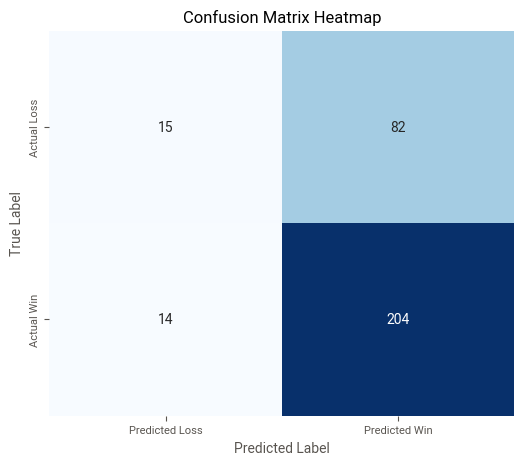

In [99]:
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Create a heatmap
plt.figure(figsize=(6, 5))  # Size of the plot
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=["Predicted Loss", "Predicted Win"], 
            yticklabels=["Actual Loss", "Actual Win"])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




What I have here is called a **confusion matrix**: it represents counts from predicted and actual values.

Perhaps, a bit of vocabulary to know in the context of binary classification:

-   the two classes in your classification are called positive class (i.e the class you're interested in, here match wins), and negative class

-   knowing that, you define true positives (TP) as the instances in your dataset that are of the positive class and are correctly classified by the model as belonging to the positive class, true negatives (TN) are the instances that are of the negative class and are correctly predicted by the model as belonging to the negative class, false positives (FP) are instances of the negative class that are misclassified by the model as instances of the positive class and false negatives (FN) are instances of the positive class that are falsely predicted by the model as belonging to the negative class

-   whether the FN or FP count is more important depends on your application
  
For our application, *predicting wins or losses is equally important so we won't emphasize false positives over false negatives*.

Applications such as applications in the medical field will generally emphasize false negatives as they mean sick patients misclassified as healthy, which could have disastrous consequences (e.g delayed treatment or death).
For spam detection, false positives are key: letting some spam filter through is fine but classifying important email as spam is not!



Can you do the same on the training set? What do you notice?

The confidence matrix in both training and test sets bears out the fact the dataset (both cases) is heavily imbalanced i.e wins are much more represented than losses in this data (which is not exactly a surprise!). 
It also looks as if the model is a bit better at predicting positives (i.e wins) than negatives (i.e losses): again, this could be due to the imbalanced nature of the data.

:::callout-important
What can we do to remedy class imbalance?

A couple of things (potentially in conjunction):
1. Use evaluation metrics appropriate for class imbalance (see more on that below)
2. Re-balance the dataset so that the majority class and the minority class have approximately the same number of samples. We can do that either by:
   
   - downsampling i.e removing samples from the majority class so that we get a proportion of samples from both classes that is similar. That might be problematic if our dataset is not large enough (not enough data to train with in the first place!) *and* we're reducing the diversity/representativity of the majority class samples
   - oversampling i.e creating synthetic examples from the minority class. One of the most famous methods for oversampling is called [SMOTE](https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjFkYzBmMTcyZThkNmVmMzgyZDZkM2EyMzFmNmMxOTdkZDY4Y2U1ZWYiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMTU0NDAwMjI2NDg3MDk0MTU4NDkiLCJlbWFpbCI6ImJlcnJhZGEuZ2hpdGFAZ21haWwuY29tIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsIm5iZiI6MTczMTY0NjQ3MiwibmFtZSI6IkdoaXRhIEJlcnJhZGEiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUNnOG9jSXdDODZ6Z1ZFTkpSNU9yRDhSenJEWXBKT3ZtNU5YUDU3ejNFNkQ3YnlDMjUySDJ6SHdNQT1zOTYtYyIsImdpdmVuX25hbWUiOiJHaGl0YSIsImZhbWlseV9uYW1lIjoiQmVycmFkYSIsImlhdCI6MTczMTY0Njc3MiwiZXhwIjoxNzMxNjUwMzcyLCJqdGkiOiJmZGFkZDZhOTE5ZmVlZDFmOGYyYWUxMGQxNWU0MjMwMTI4ZDZjMDZiIn0.AKZzkGa_6h6fhv4XyI8ag8dk-QxceD4CQTbqcbu8jG6z2c-aUDojRDfHYzcRvVFkEyZhACS0daSuBsFr_XhRFr_RmZM84_kXmBYswohA1DCsEg0aLCCi6F-1Ym_WBwT66CBQarJ3QBX2rDXpLT4r1O4YW0LC3zFS7MAxTNcoaYJCeMa72WB8axup2v2BLqPr4DdByc9JWuO33lP-THXDN70YlJ9hwt7g_gIEJ-AdqhidYBlBsKHynNCsDZA5Hk64qVhZarVvWlqGSBXAvFqRT7mbEYfKhBR0AATOHj9PB2SMMQtocdbl5YfZDgE2lO61Ywi9CFluf_soYf4x0FwVsg). You'll find the original paper that describes SMOTE [here](https://arxiv.org/abs/1106.1813) 
:::


In [96]:


y_pred_train = logit_model.predict(X)

# Convert probabilities to binary outcome (0 or 1) using threshold of 0.5
y_pred_train_binary = (y_pred_train > 0.5).astype(int)

# Confusion Matrix
conf_matrix_train = confusion_matrix(y, y_pred_train_binary)
print("Confusion Matrix:")
print(conf_matrix_train)

Confusion Matrix:
[[ 394 1879]
 [ 310 4088]]


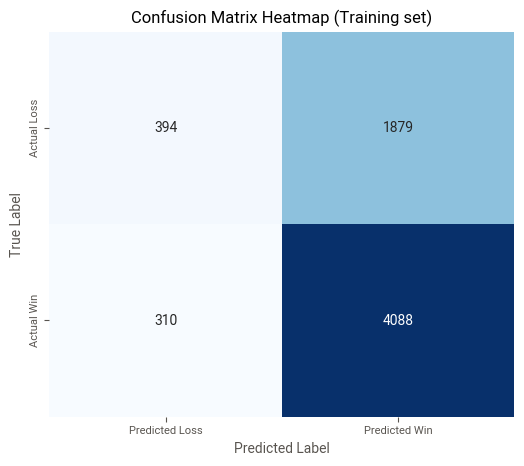

In [97]:
conf_matrix_train = confusion_matrix(y, y_pred_train_binary)

# Create a heatmap
plt.figure(figsize=(6, 5))  # Size of the plot
sns.heatmap(conf_matrix_train, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=["Predicted Loss", "Predicted Win"], 
            yticklabels=["Actual Loss", "Actual Win"])
plt.title("Confusion Matrix Heatmap (Training set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

To determine that, let's have a look at a few more metrics:

In [100]:
# Precision
precision = precision_score(y_test, y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred_binary)
print("Recall:", recall)

f1_score_test = f1_score(y_test, y_pred_binary)
print("F1 score:", f1_score_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
print("Balanced accuracy:", balanced_accuracy)

# Class Imbalance: Proportion of each class in the target variable
class_distribution = np.bincount(y_test) / len(y_test)
print("Class Imbalance (Proportions):")
print(f"Class 0 (Loss): {class_distribution[0]:.2f}, Class 1 (Win): {class_distribution[1]:.2f}")

Precision: 0.7132867132867133
Recall: 0.9357798165137615
F1 score: 0.8095238095238095
Accuracy: 0.6952380952380952
Balanced accuracy: 0.5452094958857467
Class Imbalance (Proportions):
Class 0 (Loss): 0.31, Class 1 (Win): 0.69


In [101]:
# Precision
precision_train = precision_score(y, y_pred_train_binary)
print("Precision (train):", precision_train)

# Recall
recall_train = recall_score(y, y_pred_train_binary)
print("Recall (train):", recall_train)

f1_score_train = f1_score(y, y_pred_train_binary)
print("F1 score (train):", f1_score_train)

# Accuracy
accuracy_train = accuracy_score(y, y_pred_train_binary)
print("Accuracy (train):", accuracy_train)

balanced_accuracy_train = balanced_accuracy_score(y, y_pred_train_binary)
print("Balanced accuracy (train):", balanced_accuracy_train)

# Class Imbalance: Proportion of each class in the target variable
class_distribution_train = np.bincount(y) / len(y)
print("Class Imbalance (Proportions) (Training set):")
print(f"Class 0 (Loss): {class_distribution_train[0]:.2f}, Class 1 (Win): {class_distribution_train[1]:.2f}")

Precision (train): 0.6851013909837439
Recall (train): 0.9295134151887221
F1 score (train): 0.7888084901109503
Accuracy (train): 0.6718632888622396
Balanced accuracy (train): 0.5514263072424033
Class Imbalance (Proportions) (Training set):
Class 0 (Loss): 0.34, Class 1 (Win): 0.66


The performance does not particularly degrade from training to test set (no overfitting here!).
As you can see, the accuracy metric is inflated: the model seems to perform than it actually does due to the imbalanced nature of the data! A quick look at balanced accuracy shows that and it shows that overall, our classifier is not really much better than random...

-   Accuracy

    It's the proportion of correct predictions i.e

    $$
    \begin{equation}
    accuracy = \frac{TP+TN}{P+N}\
    \end{equation}
    $$

    where $P$ is the total number of positive instances in the dataset and $N$ the total number of negative instances in the dataset.

    It's only a good metric when the classes within your dataset are balanced. Can you guess what the problem might be in case of imbalance?

    *That's what we call the accuracy paradox: an absurdly high accuracy but a bad model e.g a model that misclassifies all 100 patients as healthy when 99 are healthy and 1 has cancer. In this case, the accuracy is 99% but the model is unusable since it misclassifies the 1 case of real interest: the 1 patient with cancer!*

    How do you check if classes are balanced? Have a look at the code block above.

   What about our data? The win class is over-represented!

   So accuracy is **not** an appropriate metric in this case.

What metrics can we use in case of imbalance?

-   Precision, recall/sensitivity and F1-score

    Precision is the proportion of true positives among all the predicted positive cases.

    $$
    \begin{align}
    precision &= \frac{TP}{TP+FP}\\
              &= \frac{TP}{\textrm{all predicted positives}}
    \end{align}
    $$

    It is a good metric when the cost of false positives is high, e.g spam detection (the consequences of misclassifying a legitimate email as spam can be significant as it may result in important communications being filtered out and so the cost of a false positive is higher than that of a false negative in this case).

    Recall (or sensitivity) is the proportion of true positives among all actual positive cases.

    $$
    \begin{align}
    recall &= \frac{TP}{TP+FN}\\
              &= \frac{TP}{\textrm{all actual positives}}
    \end{align}
    $$

    High recall is critical in applications where the cost of false negatives is high, e.g medical applications. If you think back to this week's lab, a false negative meant a patient that had diabetes being misdiagnosed as being healthy resulting in delayed diagnosis and delayed appropriate treatment (and likely deterioration of the patient's condition in the meanwhile).

    Most applications, though, will need a balance between precision and recall. That's where the F-score (especially in the form of the balanced F1-score) comes in: it's the harmonic mean of precision and recall.

    $$
    \textrm{F1-score}=2\frac{precision * recall}{precision + recall}
    $$

    A more general score $F_\beta$ exists if you want to emphasize precision over recall or vice versa:

    $$
    \textrm{F}_{\beta}\textrm{-score} = (1+\beta^2)\frac{precision * recall}{(\beta^2.precision)+ recall}
    $$

-   Specificity

    The specificity is the proportion of negatives that are correctly identified as negatives.

    $$
    specificity = \frac{TN}{TN+FP}
    $$

    It is important in contexts where the classification of negatives is of high priority.

    It's particularly useful in the medical context. Consider the example of a medical test for diagnosing a disease; e.g the HbA1C blood test used to diagnose diabetes. Specificity refers to the test's ability to correctly reject healthy patients without the condition (i.e without diabetes). Supposing HbA1C had high specificity, a positive result in such test with high specificity would be useful for "ruling in" disease, i.e determining that the patient does in fact have diabetes, since the test rarely gives positive results in healthy patients.

-   Balanced accuracy

    But specificity is also used in another context. It is one of the components used to define balanced accuracy, a metric designed to overcome the problem that accuracy has when it comes to imbalanced data.

    $$
    \begin{equation}
    \textrm{balanced}\_\textrm{accuracy}= \frac{sensitivity+specificity}{2}
    \end{equation}
    $$

The closer the balanced accuracy is to 1, the better the model is able to correctly classify observations (for both classes).


**A recap of the metrics**

| **Metric**            | **Description**                                                                                      
|-------------------|----------------------|
| Accuracy              | Proportion of correct predictions                                                                    |
| Sensitivity (=recall) | The proportion of positive results out of the number of samples that were actually positive.          |
| Specificity           | The proportion of negatives that are correctly identified as negatives.                               | 
| Precision             | The proportion of true positive results out of the number of samples that were predicted as positive. | 
| Recall (=sensitivity) | The proportion of true positive results out of the number of samples that were actually positive.     | 
| F-measure             | The harmonic mean of precision and recall.                                                            | 
| Balanced accuracy     | Mean of sensitivity and specificity                                                                   | 
                                                                      


# Part 2: Classifying differently: K-NN

## 2.1 The principles

**Basic idea (images and example from [here](https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/)):**

Look at this example. Say you want to predict the class of the blue star (BS) and see whether it's a red circle (RC) or a green square (GS).

![](images/paste-1.png)

$K$-NN will take "votes" from the nearest neighbours (nearest defined based on pre-specified distance usually Euclidian distance) and will only look at $K$ neighbours (hence the $K$ in $K$-NN).

In this case, if we take $K=3$, we see that the blue star is surrounded by 3 red circles and no green squares, so the star would be classified as a red circle.

![](images/paste-2.png)

**K-NN: the steps**

1.  Load the data

2.  Initialise the value of \$K\$

3.  To get the predicted class, iterate over the test data points

    -   Calculate the distance between test data point and each row of the training set. By default, use the Euclidian distance. Other distance metrics that could be used are the Manhattan distance, Minkowski distance, Chebyshev, cosine, etc. If there are categorical variables, the Hamming distance can be used.

    -   Sort the calculated distances in ascending order based on distance values

    -   Get top $K$ rows from the sorted array of distances

    -   Get the most frequent class from these rows

    -   Return the most frequent class as the predicted class for the current test data point

## 2.2 Applying it to our problem of predicting tennis match wins

How about we try $K$-NN to the same prediction problem as before: predicting tennis match wins

In [103]:
knn = KNeighborsClassifier(n_neighbors=3)

Let's evaluate the model now, first on the training set then the test set:

In [104]:
knn.fit(X, y)

y_pred_train_knn = knn.predict(X)
# Predict on test data
y_pred_knn = knn.predict(X_test)

# Display results
print("Predicted Rounds (Encoded):", y_pred_knn)
print("Actual Rounds (Encoded):", y_test.values)

Predicted Rounds (Encoded): [0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0]
Actual Rounds (Encoded): [0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1
 1 1 1 

In [105]:
y_pred_train_binary_knn = (y_pred_train_knn > 0.5).astype(int)

# Confusion Matrix
conf_matrix_train_knn = confusion_matrix(y, y_pred_train_binary_knn)
print("Confusion Matrix (training set):")
print(conf_matrix_train_knn)

# Precision
precision_train_knn = precision_score(y, y_pred_train_binary_knn)
print("Precision (training set):", precision_train_knn)

# Recall
recall_train_knn = recall_score(y, y_pred_train_binary_knn)
print("Recall (training set):", recall_train_knn)

# Accuracy
f1_score_train_knn = f1_score(y, y_pred_train_binary_knn)
print("F1 score (training set):", f1_score_train_knn)

balanced_accuracy_train_knn = balanced_accuracy_score(y, y_pred_train_binary_knn)
print("Balanced accuracy (training set):", balanced_accuracy_train_knn)

# Class Imbalance: Proportion of each class in the target variable
class_distribution_train = np.bincount(y) / len(y)
print("Class Imbalance (Proportions) (training set):")
print(f"Class 0 (Loss): {class_distribution_train[0]:.2f}, Class 1 (Win): {class_distribution_train[1]:.2f}")

Confusion Matrix (training set):
[[1309  964]
 [ 461 3937]]
Precision (training set): 0.8033054478677821
Recall (training set): 0.8951796271032287
F1 score (training set): 0.8467577158834283
Balanced accuracy (training set): 0.7355352600980287
Class Imbalance (Proportions) (training set):
Class 0 (Loss): 0.34, Class 1 (Win): 0.66


In [106]:
y_pred_binary_knn = (y_pred_knn > 0.5).astype(int)

# Confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_binary_knn)
print("Confusion Matrix:")
print(conf_matrix_knn)

# Precision
precision_knn = precision_score(y_test, y_pred_binary_knn)
print("Precision:", precision_knn)

# Recall
recall_knn = recall_score(y_test, y_pred_binary_knn)
print("Recall:", recall_knn)

# Accuracy
f1_score_test_knn = f1_score(y_test, y_pred_binary_knn)
print("F1 score:", f1_score_test_knn)

balanced_accuracy_knn = balanced_accuracy_score(y_test, y_pred_binary_knn)
print("Balanced accuracy:", balanced_accuracy_knn)

# Class Imbalance: Proportion of each class in the target variable
class_distribution = np.bincount(y_test) / len(y_test)
print("Class Imbalance (Proportions):")
print(f"Class 0 (Loss): {class_distribution[0]:.2f}, Class 1 (Win): {class_distribution[1]:.2f}")

Confusion Matrix:
[[ 31  66]
 [ 40 178]]
Precision: 0.7295081967213115
Recall: 0.8165137614678899
F1 score: 0.7705627705627706
Balanced accuracy: 0.5680506951669346
Class Imbalance (Proportions):
Class 0 (Loss): 0.31, Class 1 (Win): 0.69


How does $K$-NN compare to logistic regression?

*This model degrades somewhay between training/test set (potential overfitting at play). It performs much better than logistic regression on both training and test sets but might suffer from potential lack of generalization. Further investigation on the right value of $K$ might be needed.* Again just as with logistic regression, balanced accuracy (on the test set at least) makes for a mixed picture: the model doesn't look much better than random in its predictions.

📚 **Notes**: When independent variables in training data are measured in different units, it is important to standardize variables before calculating distance. So, it is usually good practice to normalize the dataset before applying $K$-NN. You can do that with `StandardScaler` for example. You can have a look at [this page](https://www.geeksforgeeks.org/how-to-standardize-data-in-a-pandas-dataframe/) to see ways to standardize your data

Because it relies on distance calculations, $K$-NN is sensitive to outliers

🎯 ACTION POINT: How should I go about modifying my $K$-NN model and its evaluation?
